# Part 1.6

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Update Matplotlib parameters
plt.rcParams.update({
    'font.family': 'serif',              # Set the font family
    'font.serif': ['Times New Roman'],   # Use a specific serif font
    'font.size': 16,                     # Set the general font size
    'axes.titlesize': 20,                # Set the font size of the title
    'axes.labelsize': 16,                # Set the font size of axis labels
    'font.style': 'italic',              # Set the font style to italic
    'figure.dpi': 400   
})
category_color_pal = sns.color_palette("hls", 8)#sns.color_palette("husl", 8)
continuous_color_pal = sns.color_palette("rocket_r", as_cmap=True)

## Example 1 | Synthetic Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

#### Load the geographic voter data

In [4]:
data_path = "geographic_voter_data.csv"
df = pd.read_csv(data_path)

#### Create GeoDataFrame

In [5]:
df['geometry'] = df.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

#### Load a basemap for Pittsburgh and define boundaries

In [27]:
world = gpd.read_file('geo')
pa = world[world['name'] == 'Pennsylvania']

#### Plot voters on the map

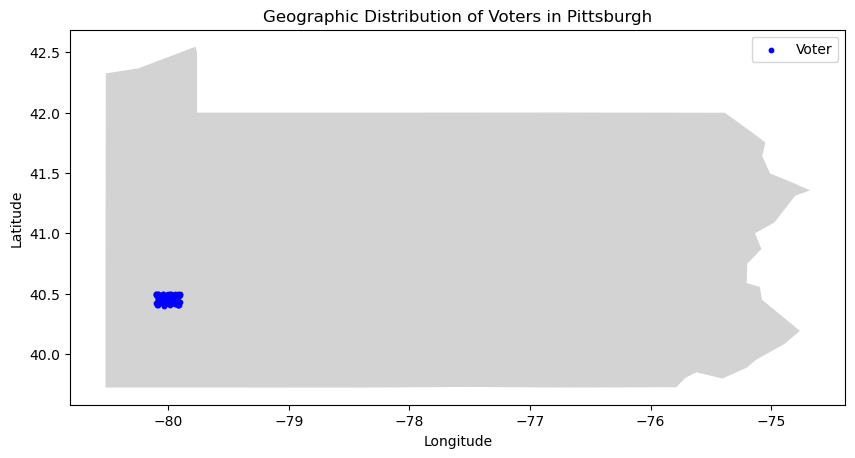

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
pa.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='blue', markersize=10, label='Voter')

ax.set_title("Geographic Distribution of Voters in Pittsburgh")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()

## Example 2 | Restaurants by Zipcode and Distance to Downtown

#### Step 1: Install Required Libraries

Ensure you have the required libraries installed.

In [2]:
#pip install geopandas folium osmnx
#pip install geopy

In [54]:
import osmnx as ox
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.distance import geodesic

#### Step 2: Load Public Geographic Data

We'll use osmnx to download restaurant locations in Pittsburgh.

In [50]:
# Define the place to search
place = "Pittsburgh, Pennsylvania, USA"

# Get restaurants from OpenStreetMap
restaurants = ox.features_from_place(place, tags={'amenity': 'restaurant'})

# Convert to GeoDataFrame
restaurants = restaurants[['geometry', 'name']]
restaurants = restaurants[restaurants.geometry.type == 'Point']

restaurants.head()


geometry                  name
element id                                                         
node    361975506  POINT (-79.95597 40.46543)        Tram's Kitchen
        412045724  POINT (-79.94994 40.46233)          Thai Cuisine
        532136017  POINT (-79.89113 40.48699)           TGI Fridays
        532136142  POINT (-79.88886 40.48695)          Walnut Grill
        533755434  POINT (-79.98989 40.42886)  Mantini's Wood Fired

In [81]:
from Weidman_Figures import *

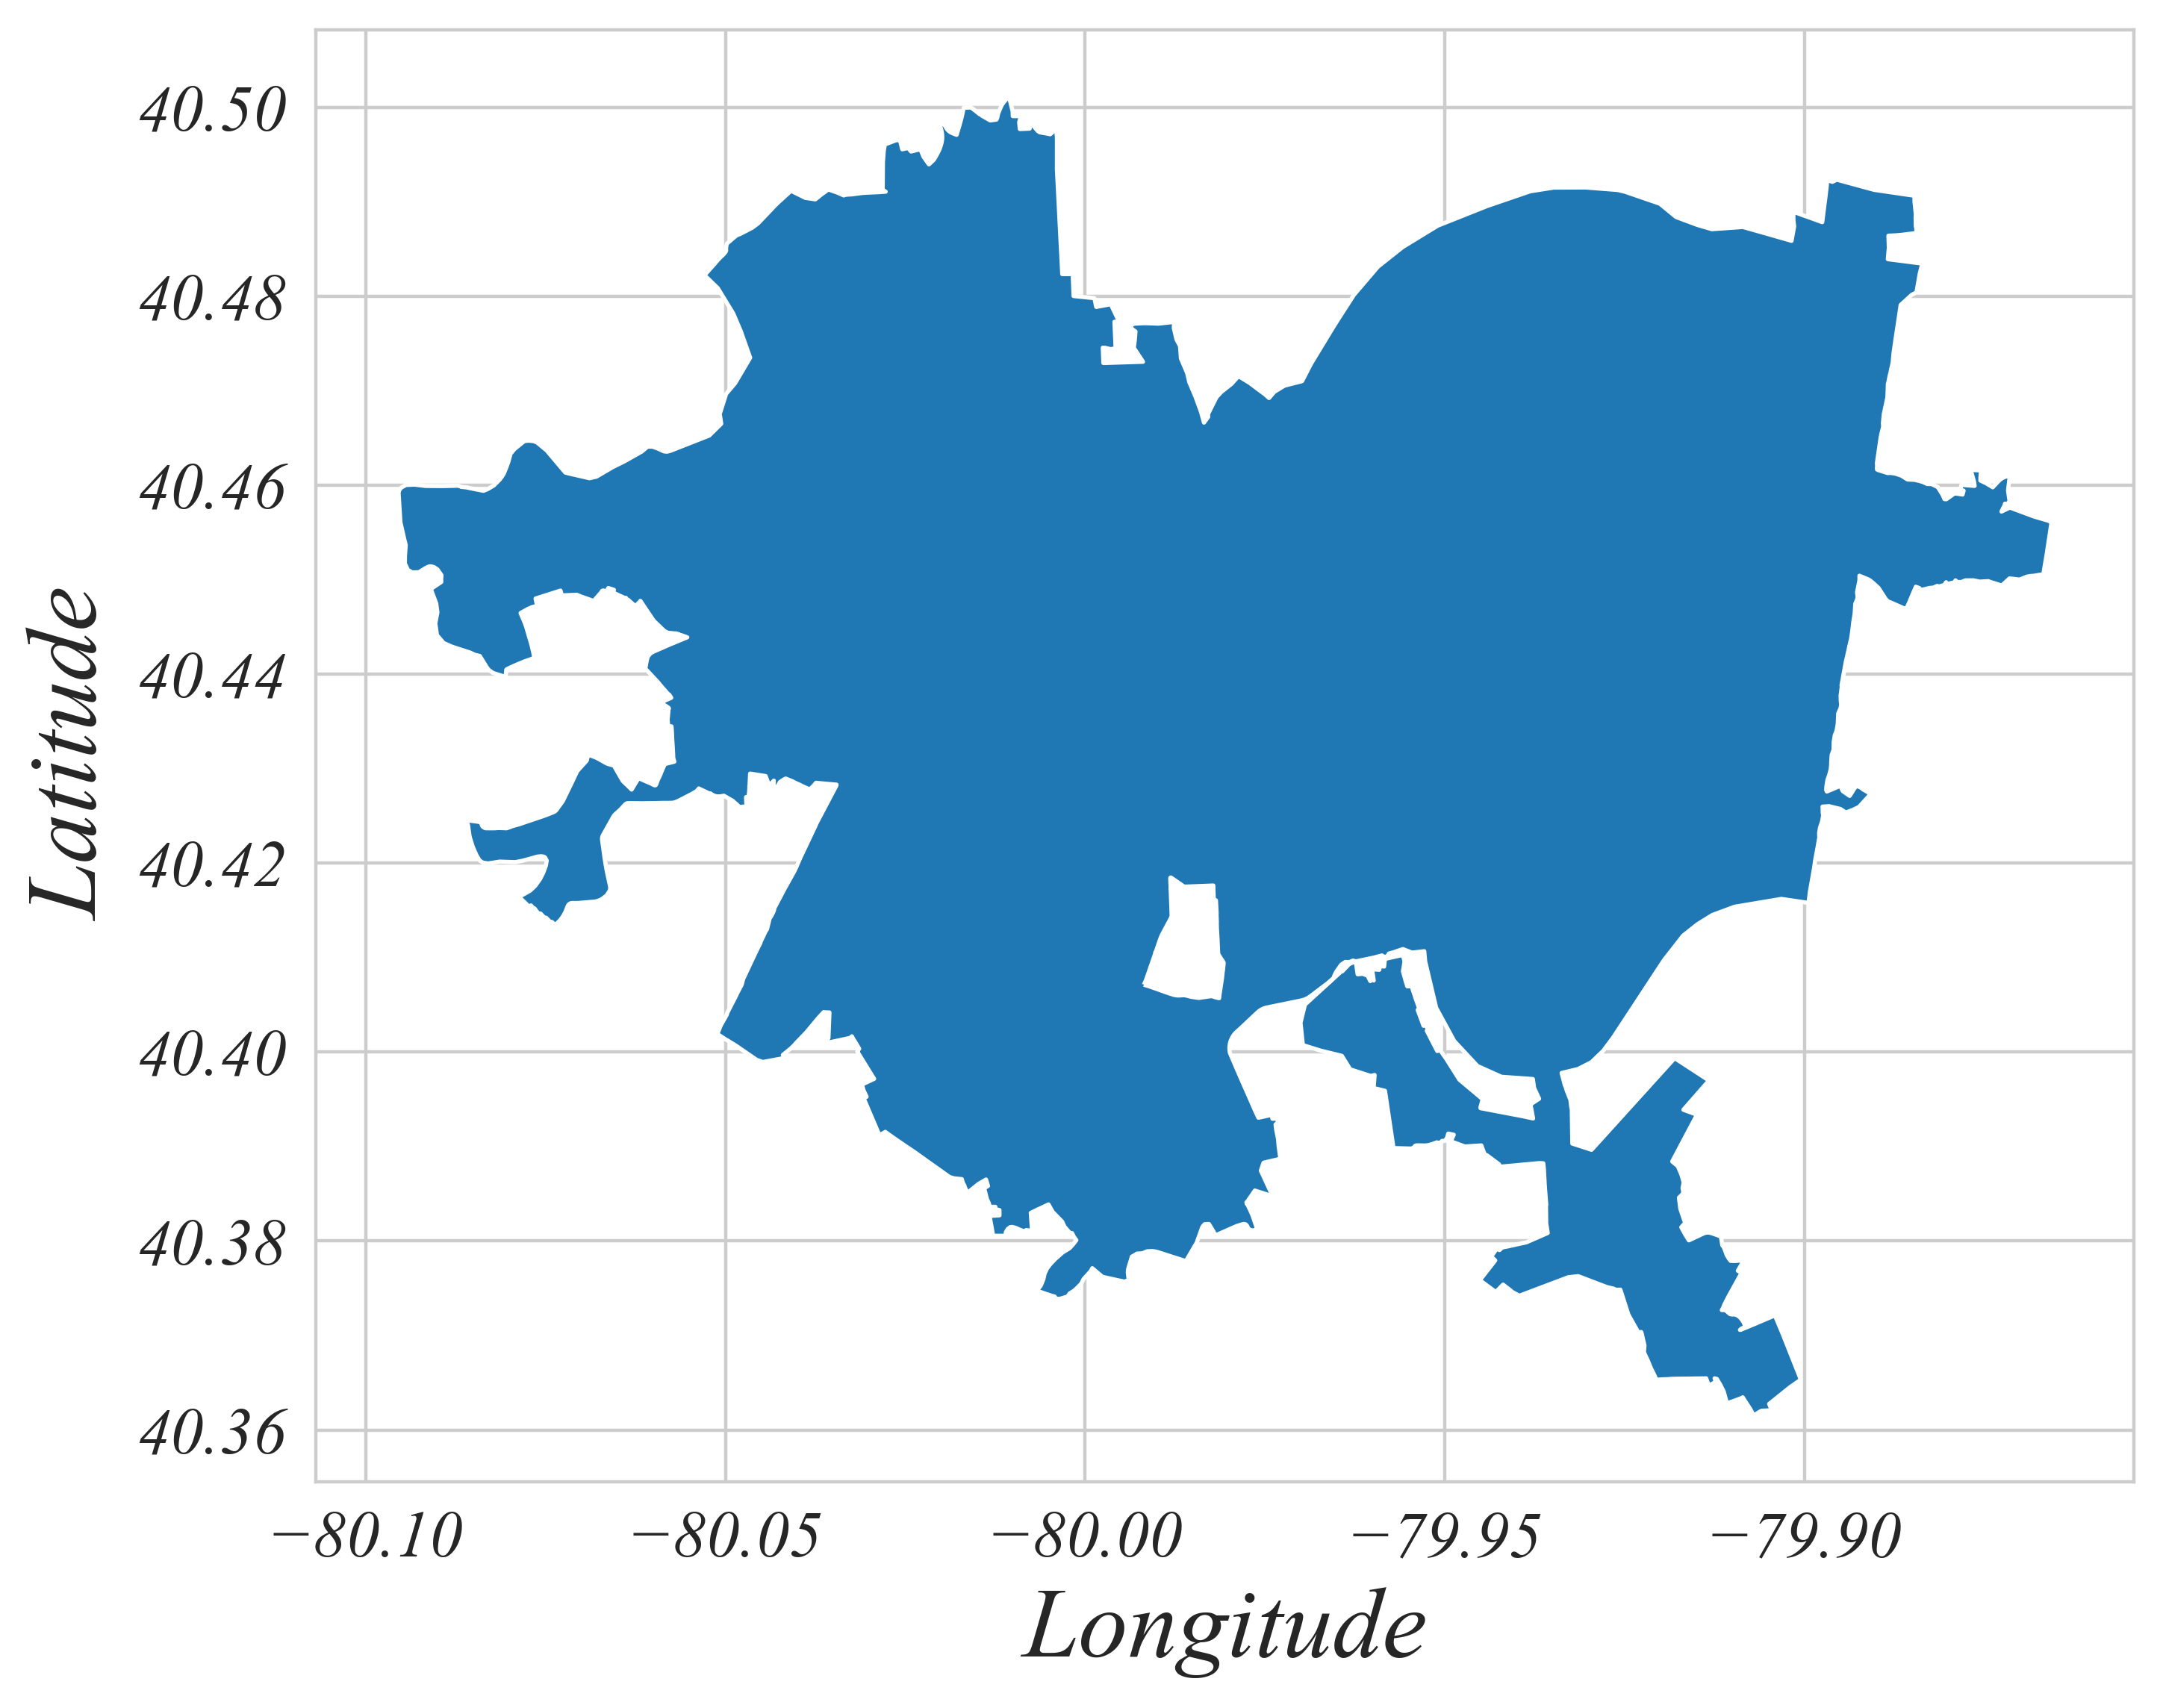

In [91]:
# Get Pittsburgh's city boundary from OpenStreetMap
pittsburgh_boundary = ox.geocode_to_gdf("Pittsburgh, Pennsylvania, USA")

fig, ax = Weid_Fig(fontsize=24)

pittsburgh_boundary.plot(ax = ax)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.tight_layout()
plt.savefig('Part_2_3/i/1.png')


In [56]:
# Load ZIP code boundaries from Census TIGER/Line
zip_url = "https://www2.census.gov/geo/tiger/TIGER2023/ZCTA520/tl_2023_us_zcta520.zip"
zipcodes = gpd.read_file(zip_url)

# Convert to standard CRS (latitude/longitude)
zipcodes = zipcodes.to_crs("EPSG:4326")


#### Step 3: Filter ZIP Codes for Pittsburgh
We'll filter ZIP codes that intersect Pittsburgh.


In [134]:
# Ensure ZIP codes and city boundary use the same CRS
pittsburgh_boundary = pittsburgh_boundary.to_crs(zipcodes.crs)

# Use spatial intersection to get ZIP codes inside Pittsburgh
pittsburgh_zipcodes = gpd.overlay(zipcodes, pittsburgh_boundary, how="intersection", keep_geom_type=True)

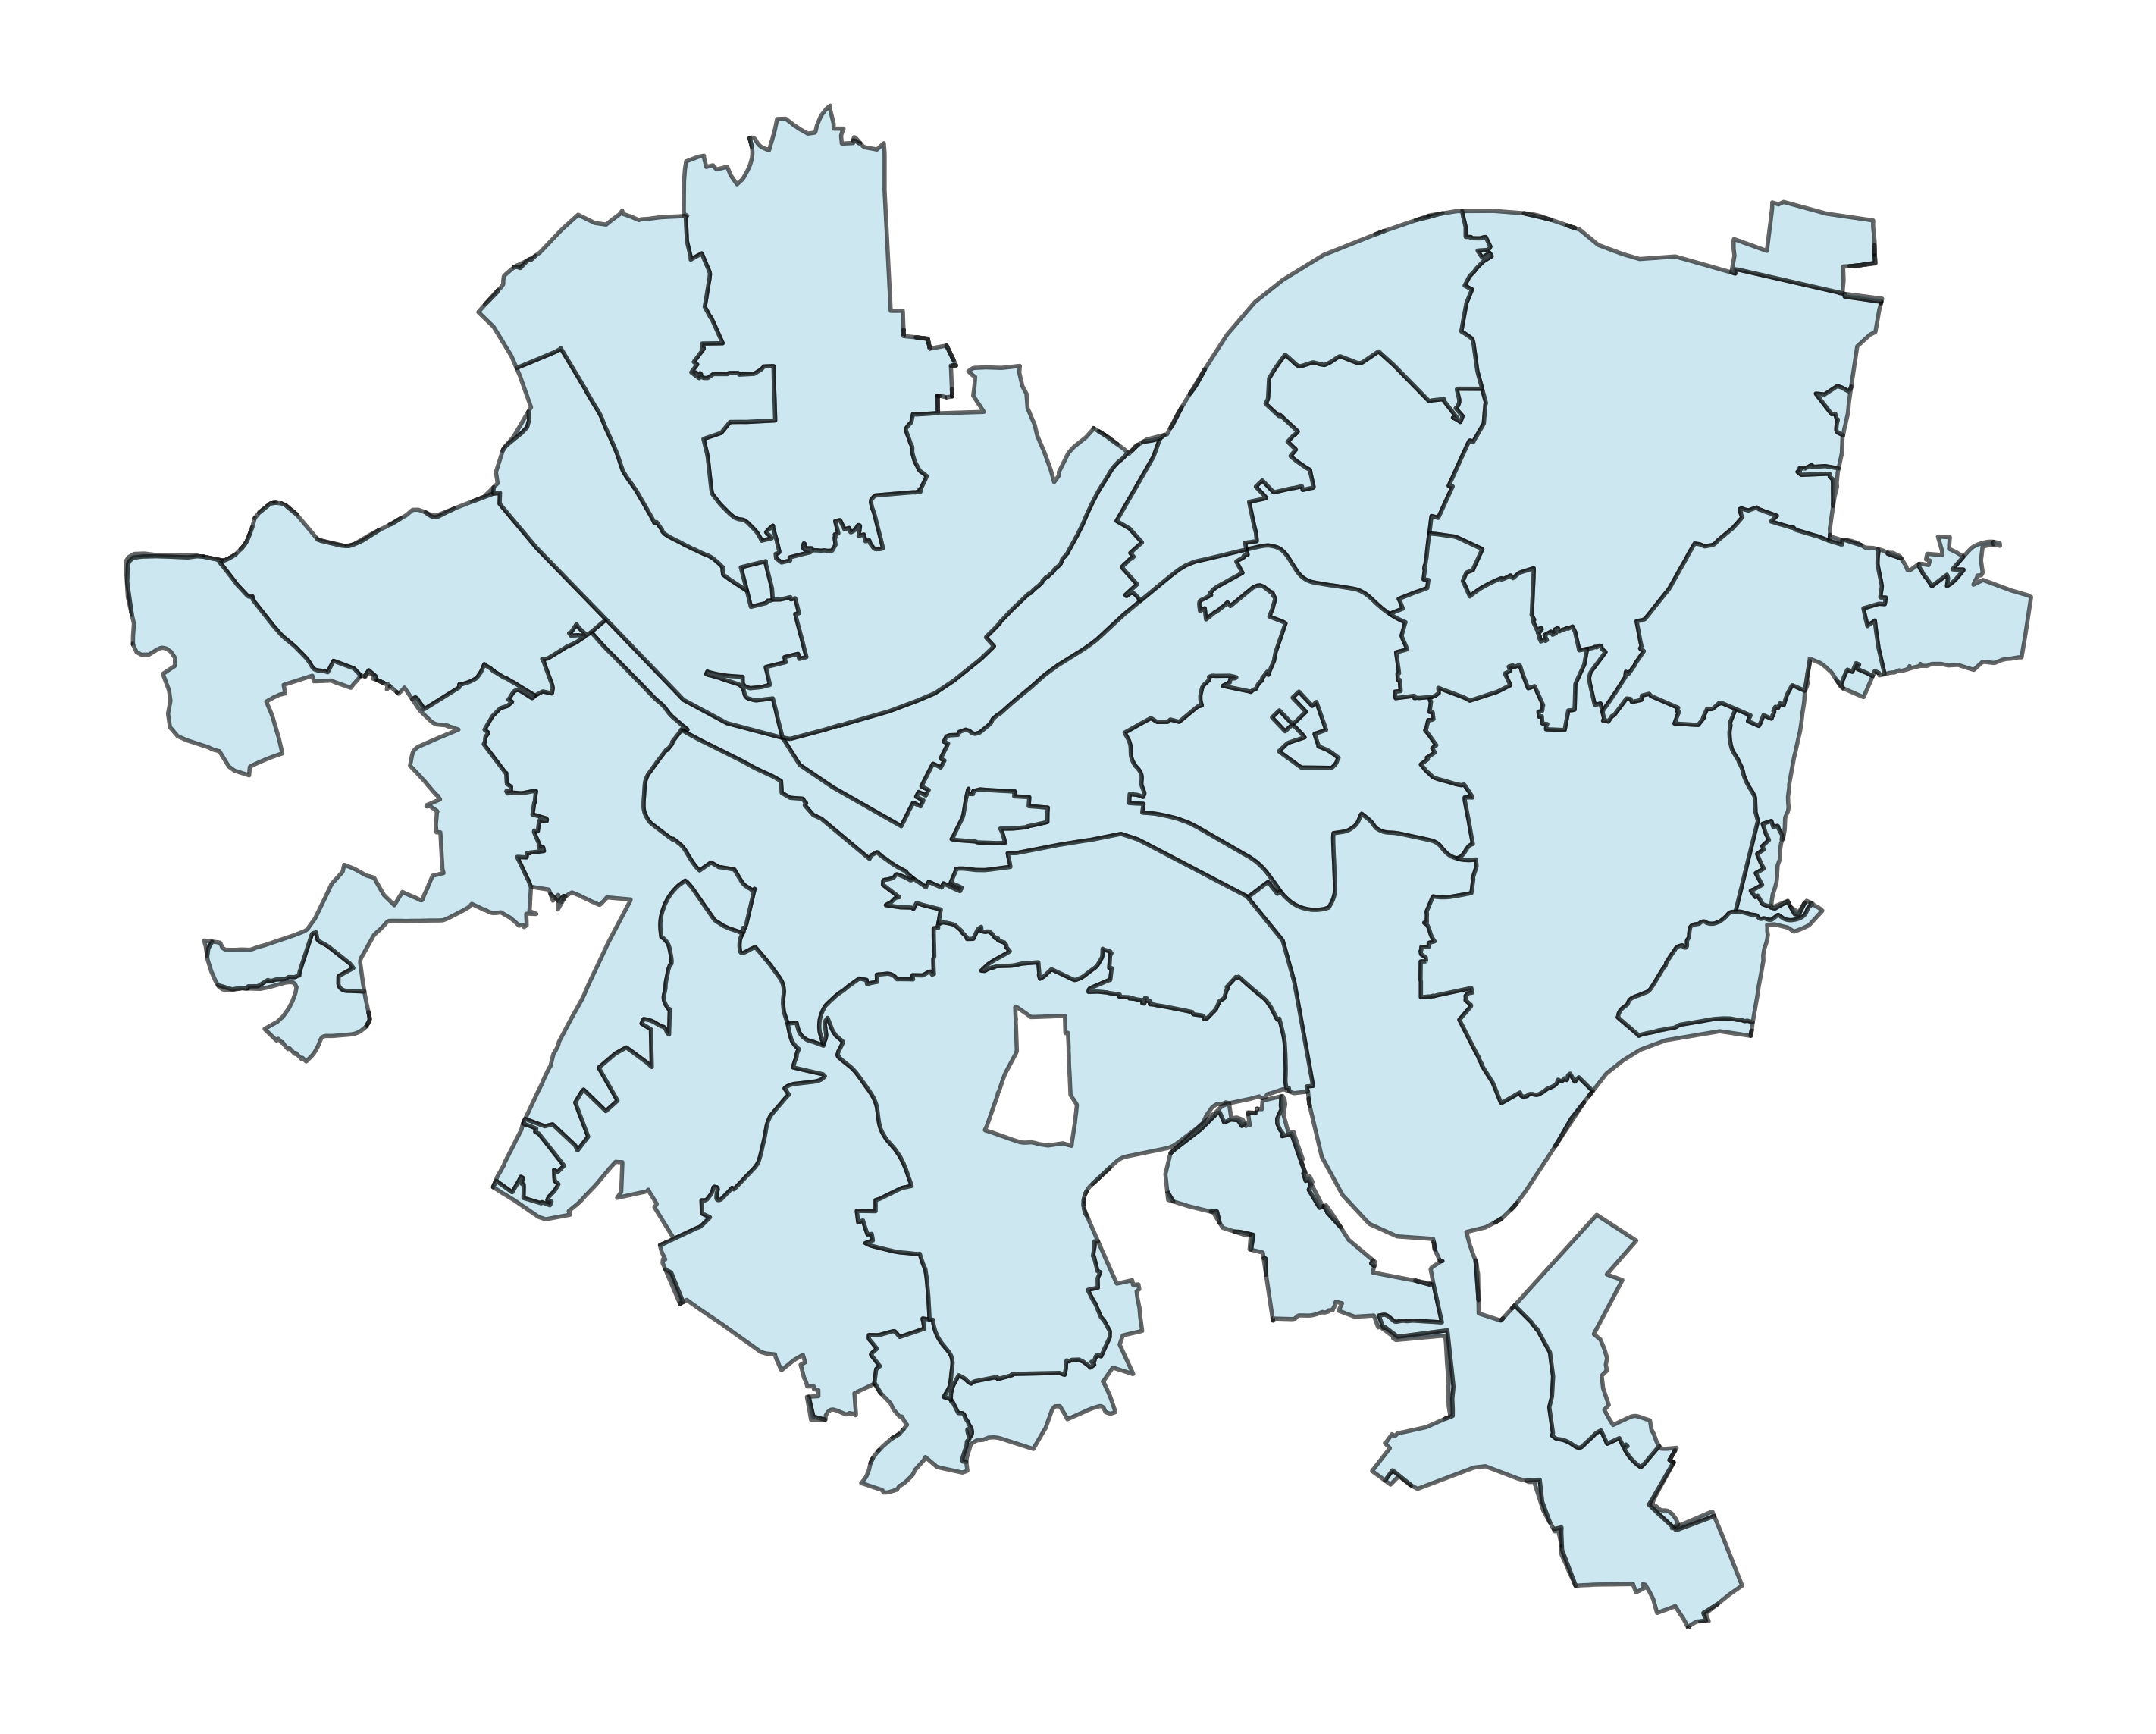

In [142]:
fig, ax = Weid_Fig(fontsize=24)

pittsburgh_zipcodes.plot(edgecolor="black", facecolor="lightblue", alpha=0.6, ax=ax)
plt.grid(False)
sns.despine(left=True, right=True, top=True, bottom=True)
plt.yticks([])
plt.xticks([])
plt.tight_layout()
plt.savefig('Part_2_3/i/2.png')

In [136]:
# Create a Folium map centered on Pittsburgh
m = folium.Map(location=[40.4406, -79.9959], zoom_start=12)

# Add Pittsburgh ZIP code boundaries (refined version)
folium.GeoJson(
    pittsburgh_zipcodes, 
    name="Pittsburgh ZIP Codes",
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.3
    }
).add_to(m)

# Add restaurant points
for idx, row in restaurants.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=3,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.6,
        popup=row.get("name", "Unnamed Restaurant"),
    ).add_to(m)

# Display the interactive map
m.save('Part_2_3/i/4.html')
m

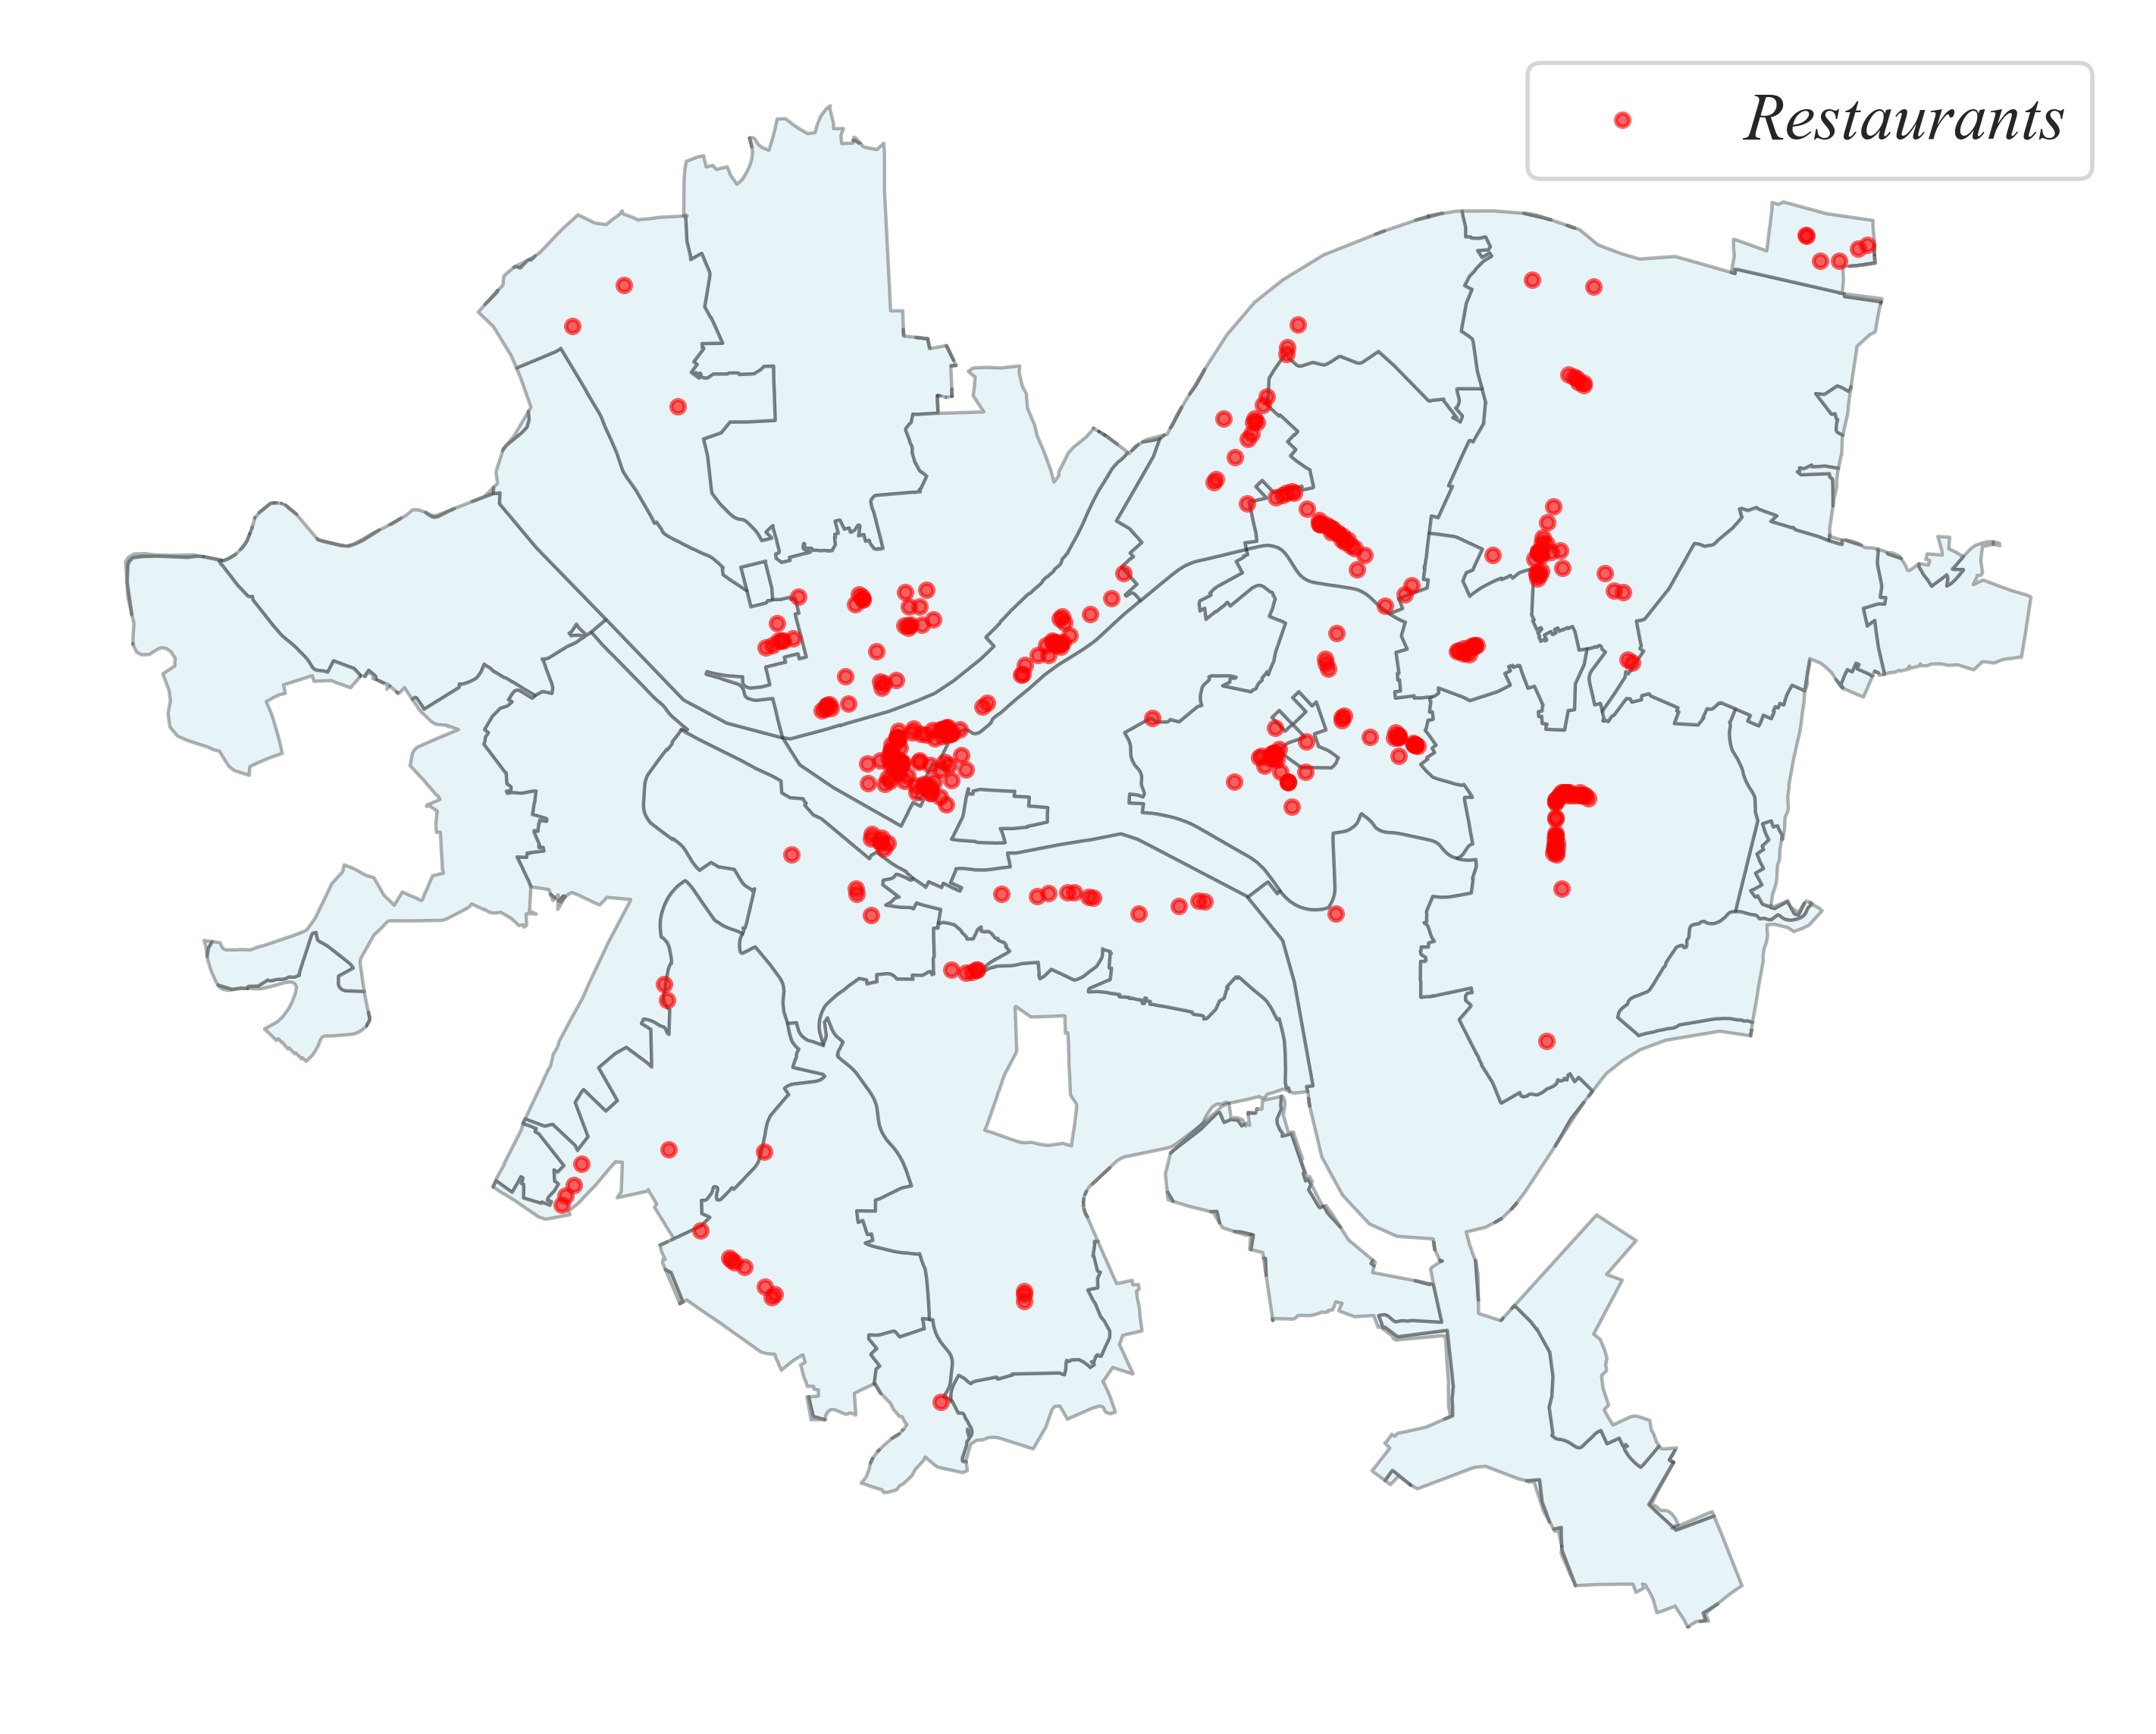

In [141]:
fig, ax = Weid_Fig(fontsize=24)

# Plot Pittsburgh ZIP code boundaries
pittsburgh_zipcodes.plot(ax=ax, linewidth=0.8, edgecolor="black", facecolor="lightblue", alpha=0.3)

# Plot restaurant locations as red dots
restaurants.plot(ax=ax, markersize=10, color="red", alpha=0.6, label="Restaurants")

# Customize plot appearance
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.legend()

plt.tight_layout()

plt.savefig('Part_2_3/i/4.png')


#### Step 4: Count Restaurants per ZIP Code
We'll perform a spatial join to count how many restaurant points fall inside each ZIP code.


In [143]:
# Convert restaurants to GeoDataFrame
restaurants_gdf = gpd.GeoDataFrame(restaurants, geometry=restaurants.geometry, crs="EPSG:4326")

# Perform a spatial join to count restaurants per ZIP code
restaurants_per_zip = gpd.sjoin(pittsburgh_zipcodes, restaurants_gdf, predicate="contains")

# Count restaurants per ZIP code
zip_counts = restaurants_per_zip.groupby("ZCTA5CE20").size().reset_index(name="restaurant_count")

# Merge restaurant counts back into the ZIP code dataset
pittsburgh_zipcodes = pittsburgh_zipcodes.merge(zip_counts, on="ZCTA5CE20", how="left").fillna(0)

# Display ZIP codes with restaurant counts
pittsburgh_zipcodes[["ZCTA5CE20", "restaurant_count"]].head()


ZCTA5CE20  restaurant_count
0     15222              77.0
1     15229               0.0
2     15202               0.0
3     15122               0.0
4     15236               0.0

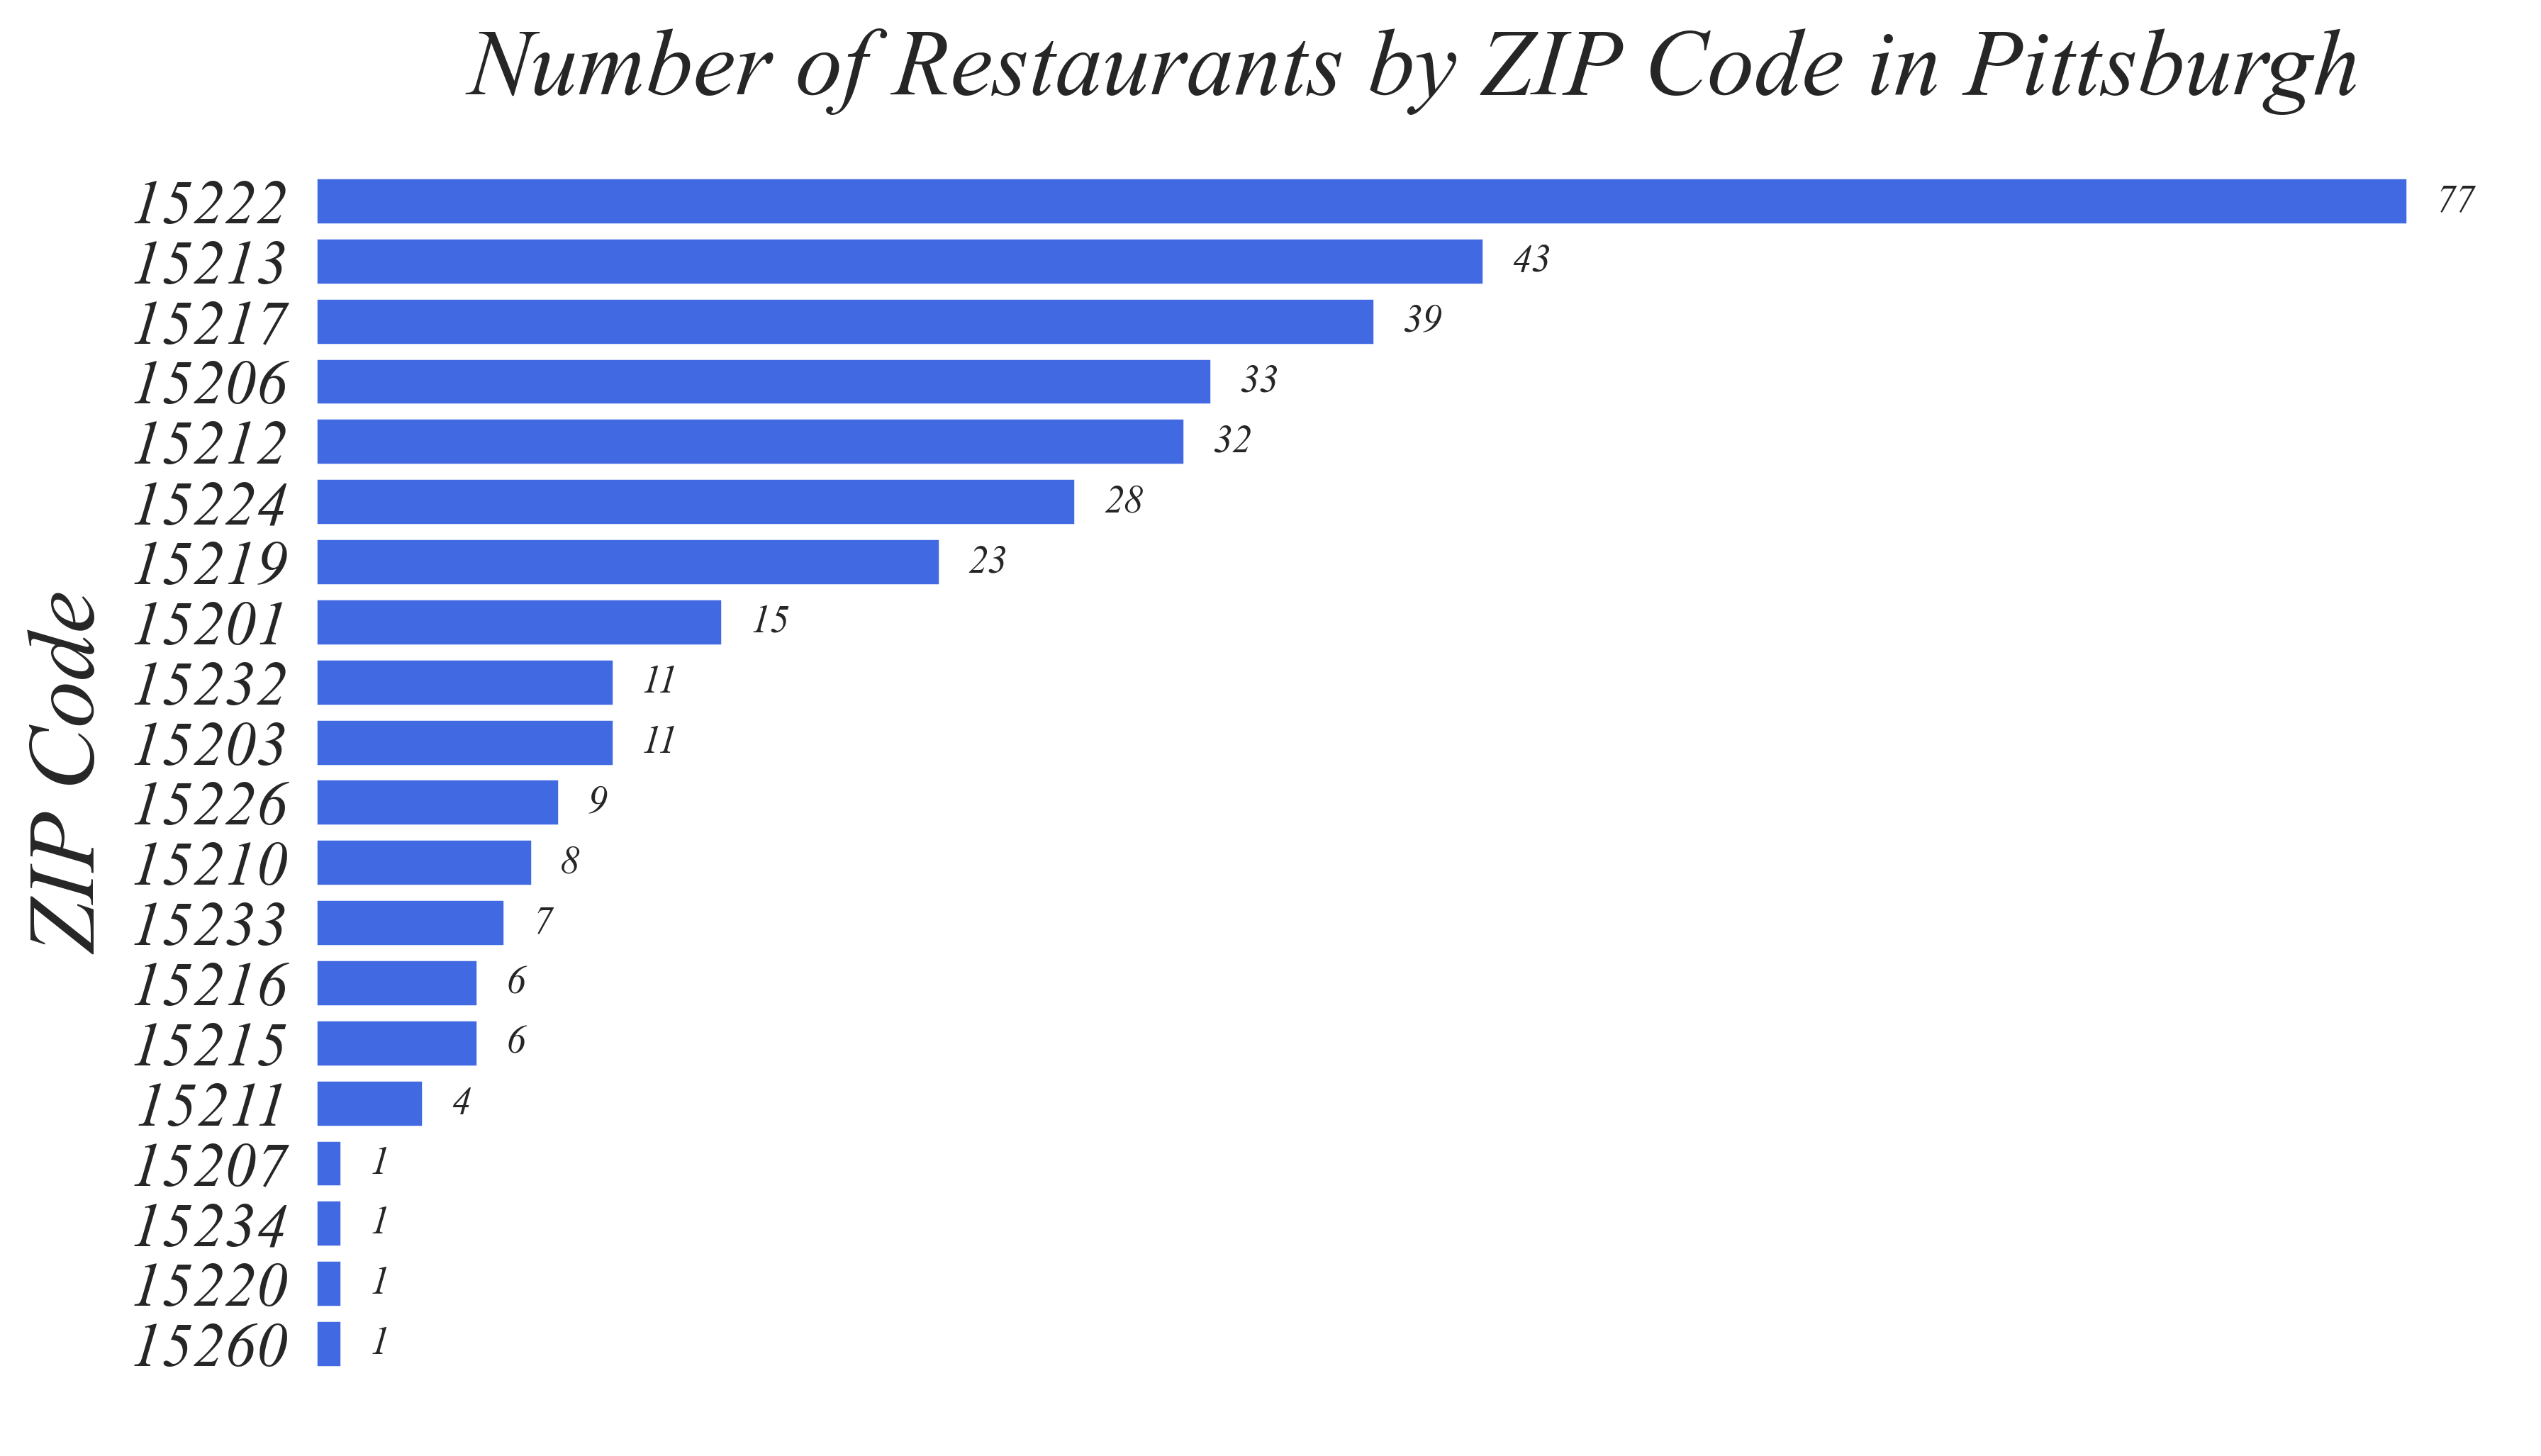

In [152]:
zip_counts = zip_counts.sort_values(by="restaurant_count", ascending=True)

fig, ax = Weid_Fig(fontsize=24)

# Plot horizontal bar chart
bars = ax.barh(zip_counts["ZCTA5CE20"], zip_counts["restaurant_count"], color="royalblue")

# Add text labels at the end of each bar
for bar in bars:
    ax.text(
        bar.get_width() + 1,  # Position text slightly beyond bar width
        bar.get_y() + bar.get_height()/2,  # Center text on bar
        str(int(bar.get_width())),  # Convert count to string for display
        va='center',  # Align text vertically
        fontsize=10
    )

# Labels and formatting
ax.set_ylabel("ZIP Code")
ax.set_title("Number of Restaurants by ZIP Code in Pittsburgh")
ax.grid(False)
ax.set_frame_on(False)
ax.set_xticks([])

plt.savefig('Part_2_3/i/5.png')


#### Step 5: Compute ZIP Code Centroids
We compute the geometric center of each ZIP code

In [162]:
# Compute the centroid for each ZIP code
pittsburgh_zipcodes["centroid"] = pittsburgh_zipcodes.geometry.centroid

# Convert centroids to lat/lon pairs
pittsburgh_zipcodes["centroid_coords"] = pittsburgh_zipcodes["centroid"].apply(lambda x: (x.y, x.x))

/var/folders/xc/wlq2_w5j6zncfqys5_nfww4w0000gn/T/ipykernel_92617/1567063114.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pittsburgh_zipcodes["centroid"] = pittsburgh_zipcodes.geometry.centroid


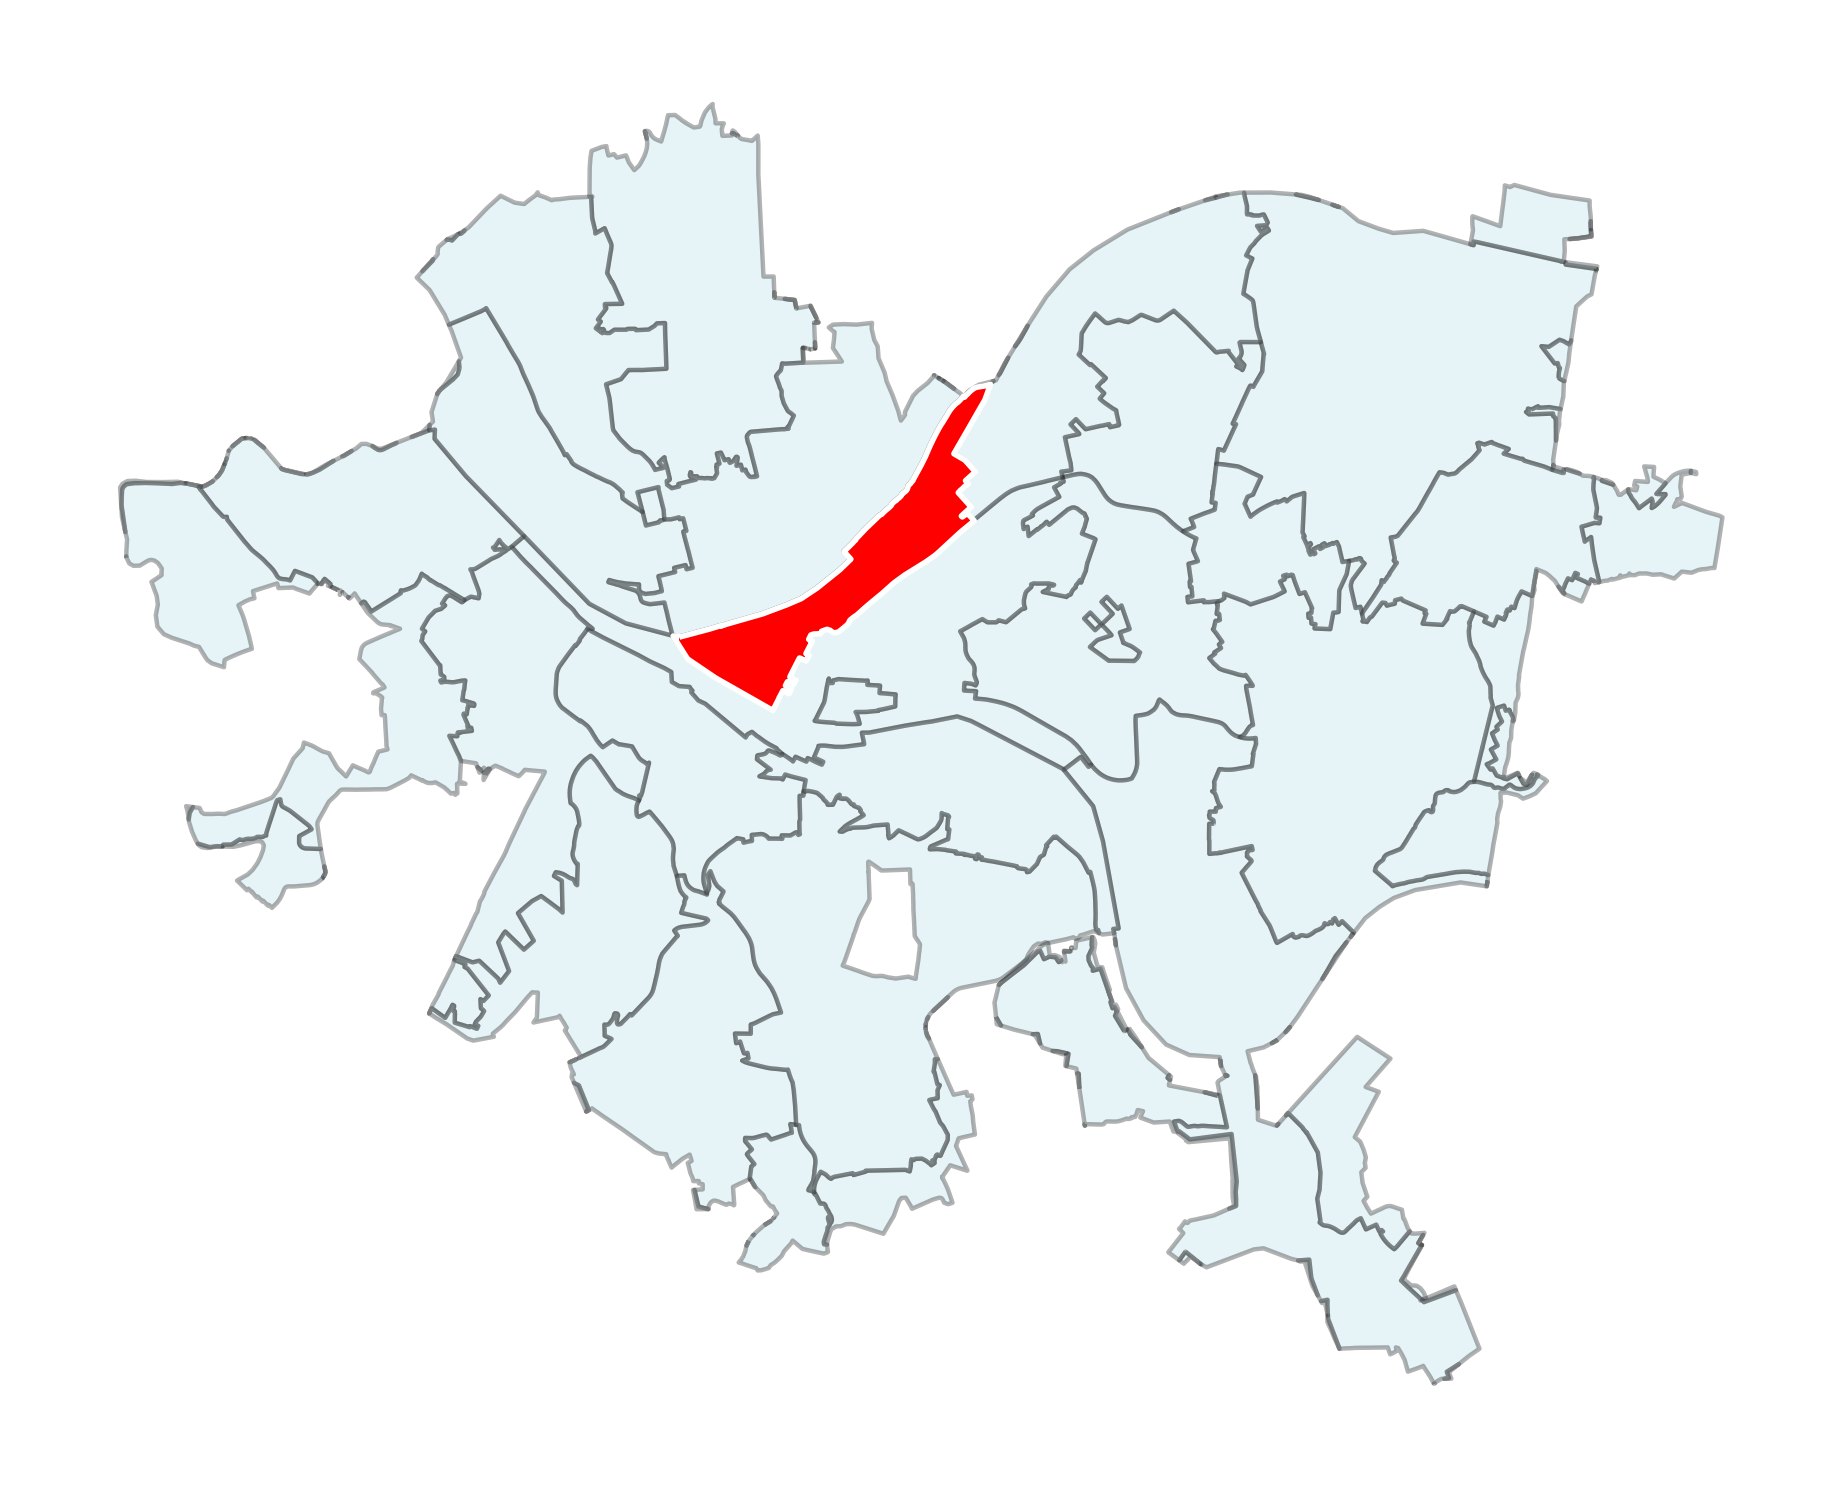

In [211]:
fig, ax = Weid_Fig(height=4, fontsize=24)

# Plot Pittsburgh ZIP code boundaries
pittsburgh_zipcodes["geometry"].plot(ax=ax, linewidth=0.8, edgecolor="black", facecolor="lightblue", alpha=0.3)

pittsburgh_zipcodes[pittsburgh_zipcodes["ZCTA5CE20"] == "15222"]['geometry'].plot(ax=ax, color='red')

ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.tight_layout()

plt.savefig('Part_2_3/i/6_pre.png')

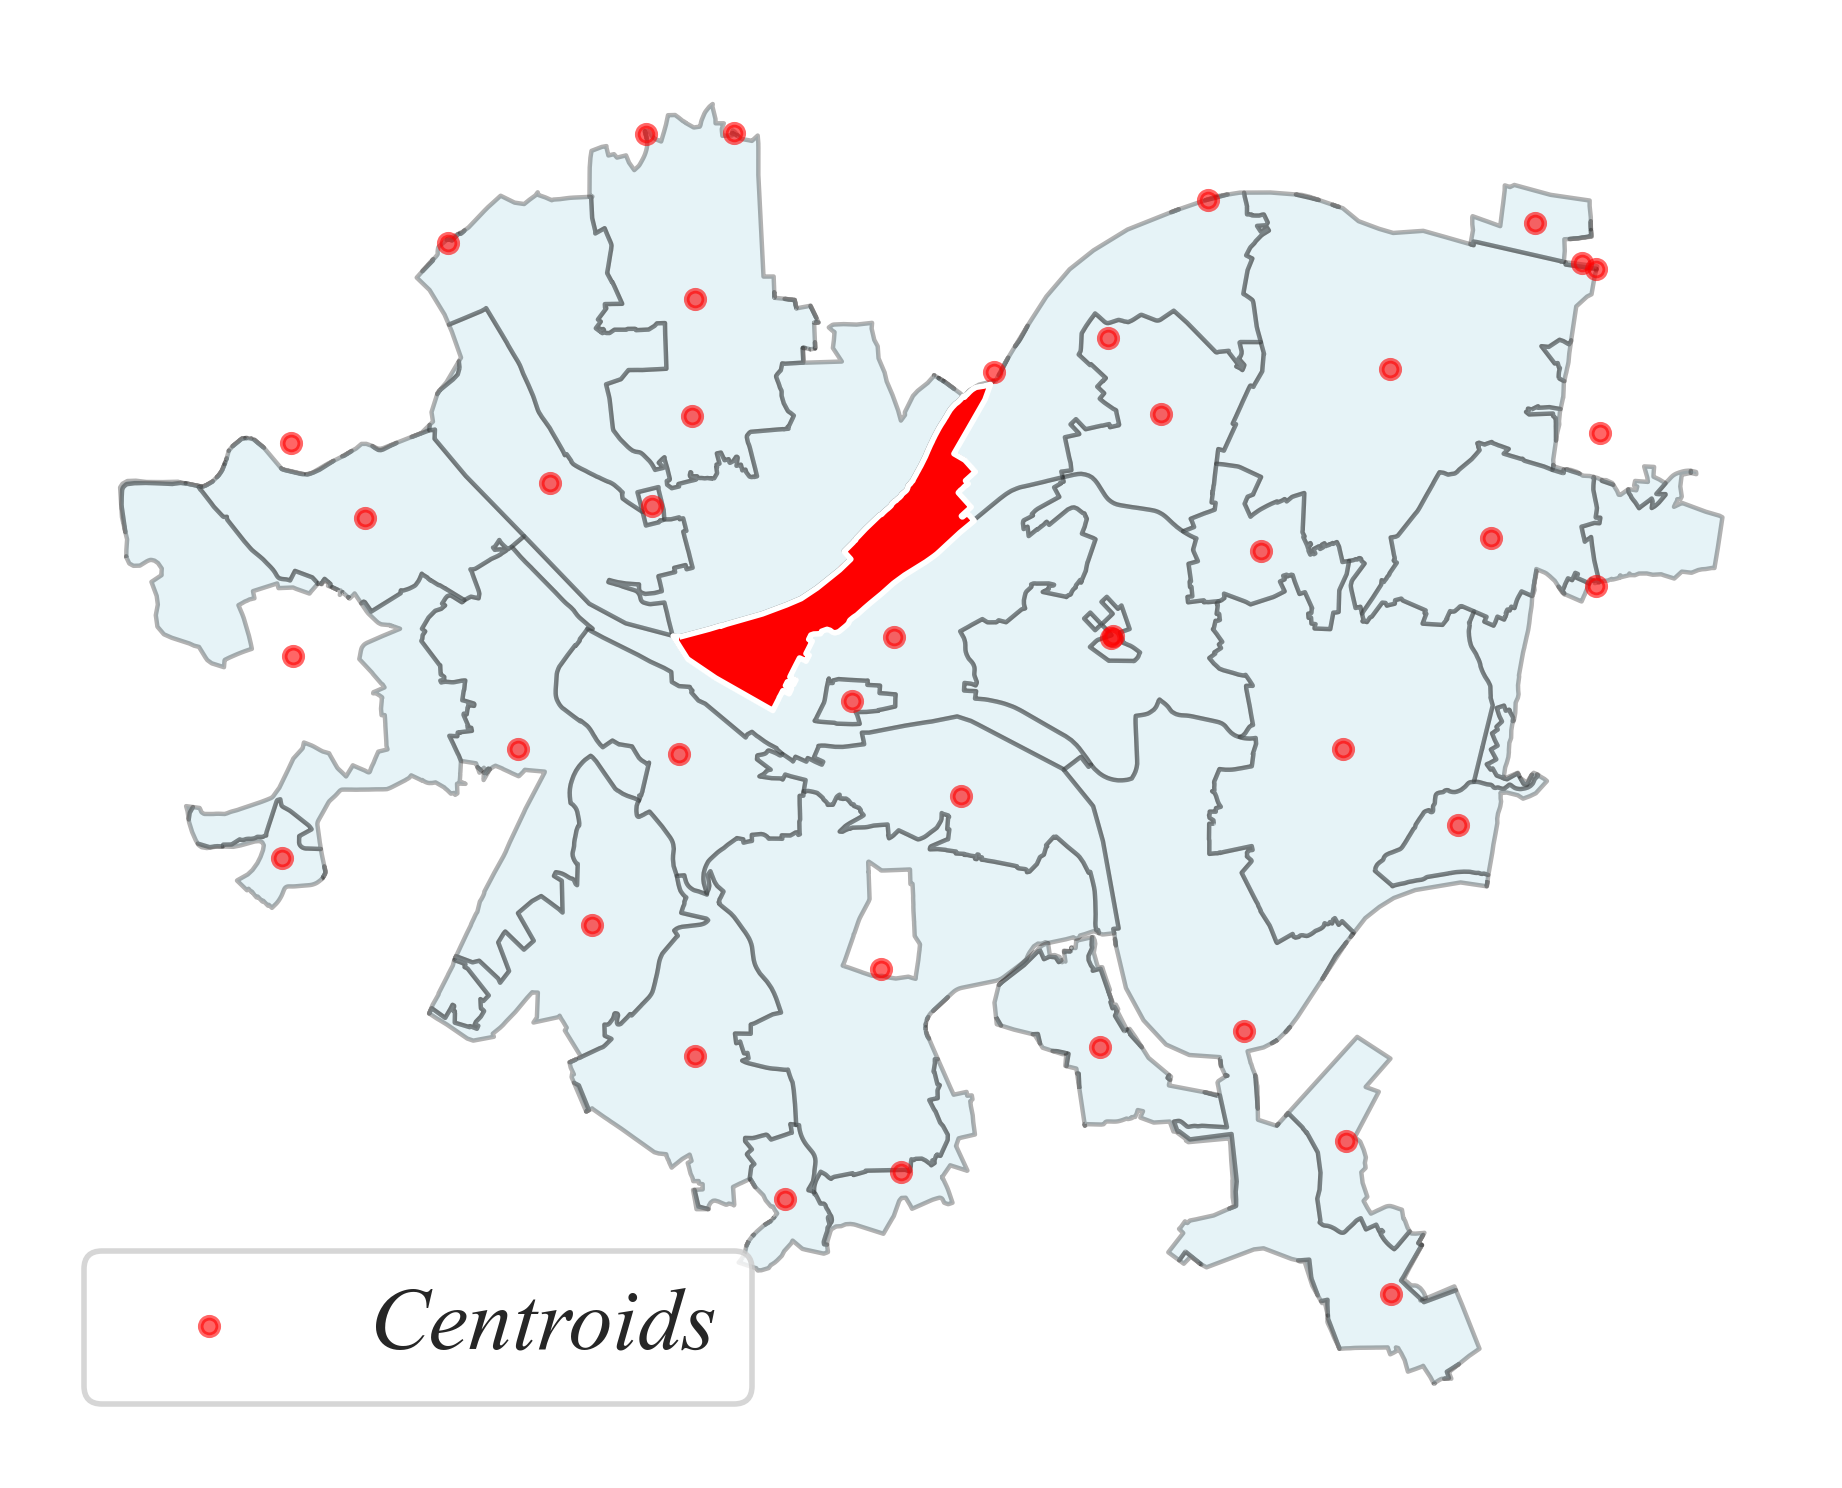

In [210]:
fig, ax = Weid_Fig(height=4,fontsize=24)

# Plot Pittsburgh ZIP code boundaries
pittsburgh_zipcodes["geometry"].plot(ax=ax, linewidth=0.8, edgecolor="black", facecolor="lightblue", alpha=0.3)

pittsburgh_zipcodes["centroid"].plot(ax=ax, markersize=10, color="red", alpha=0.6, label="Centroids")

pittsburgh_zipcodes[pittsburgh_zipcodes["ZCTA5CE20"] == "15222"]['geometry'].plot(ax=ax, color='red')

ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
ax.legend()

plt.tight_layout()

plt.savefig('Part_2_3/i/6.png')

In [154]:
# Find the centroid of ZIP code 15222 (downtown Pittsburgh)
downtown_zip = pittsburgh_zipcodes[pittsburgh_zipcodes["ZCTA5CE20"] == "15222"]

# Get its centroid coordinates
downtown_centroid = downtown_zip["centroid_coords"].values[0]

In [155]:
# Compute distance from each ZIP centroid to downtown ZIP centroid
pittsburgh_zipcodes["distance_to_downtown"] = pittsburgh_zipcodes["centroid_coords"].apply(
    lambda x: geodesic(x, downtown_centroid).miles
)

# Display ZIP codes with distances
pittsburgh_zipcodes[["ZCTA5CE20", "distance_to_downtown", "restaurant_count"]].head()

ZCTA5CE20  distance_to_downtown  restaurant_count
0     15222              0.000000              77.0
1     15229              3.641139               0.0
2     15202              3.909019               0.0
3     15122              6.811068               0.0
4     15236              4.044545               0.0

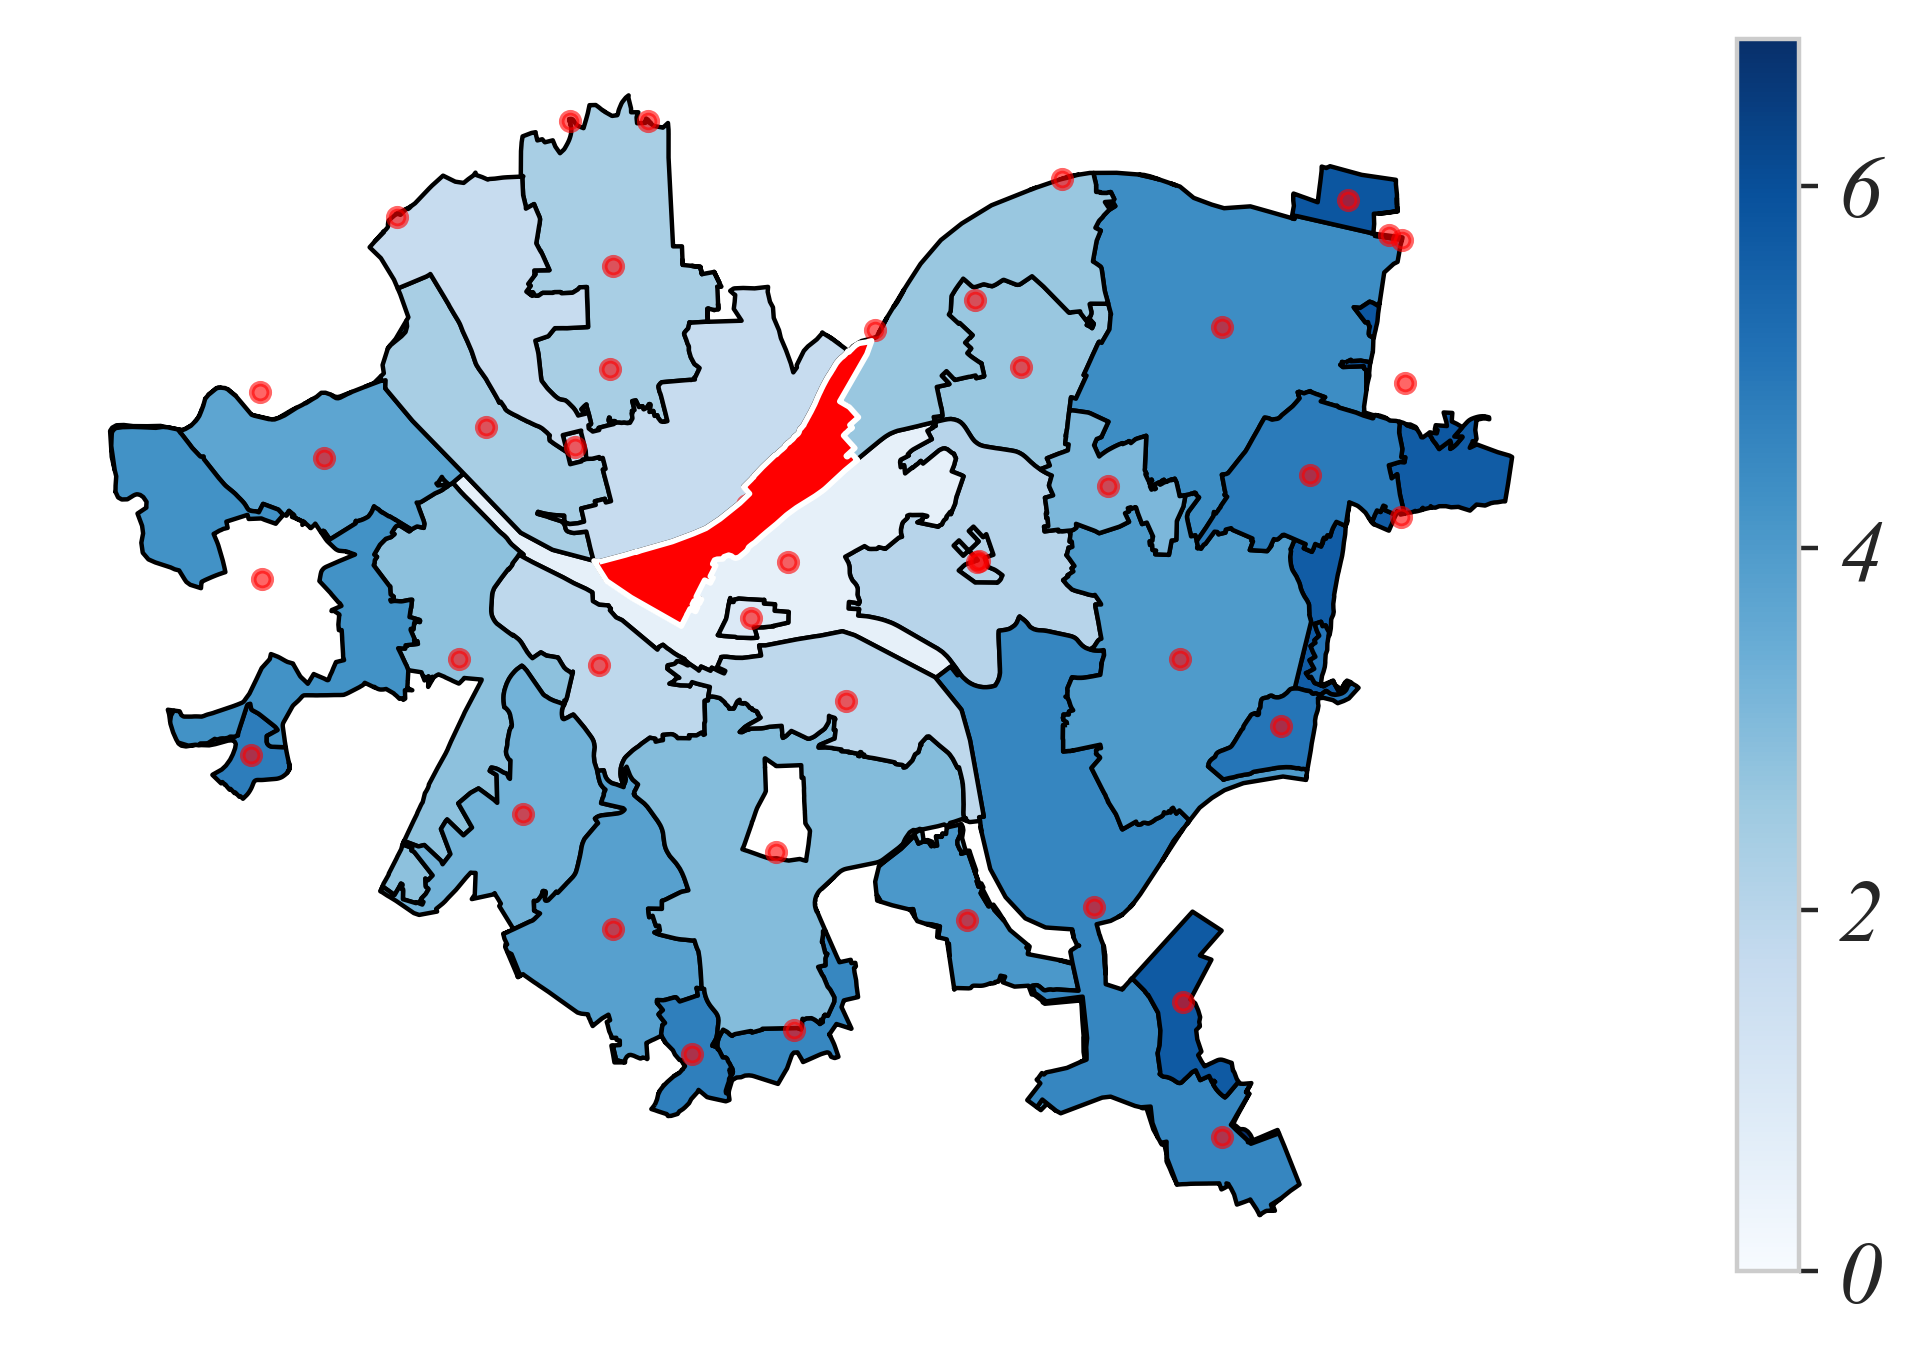

In [209]:
fig, ax = Weid_Fig(height=4, fontsize=24)

# Normalize population values for color mapping
norm = plt.Normalize(vmin=pittsburgh_zipcodes["distance_to_downtown"].min(), vmax=pittsburgh_zipcodes["distance_to_downtown"].max())
cmap = plt.get_cmap("Blues")

# Plot the ZIP code areas with population-based coloring
pittsburgh_zipcodes.plot(ax=ax, linewidth=0.8, edgecolor="black",
                         facecolor=[cmap(norm(val)) for val in pittsburgh_zipcodes["distance_to_downtown"]])

pittsburgh_zipcodes["centroid"].plot(ax=ax, markersize=10, color="red", alpha=0.6, label="Centroids")

pittsburgh_zipcodes[pittsburgh_zipcodes["ZCTA5CE20"] == "15222"]['geometry'].plot(ax=ax, color='red')

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("")

# Title and axis formatting
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.savefig('Part_2_3/i/6a.png')


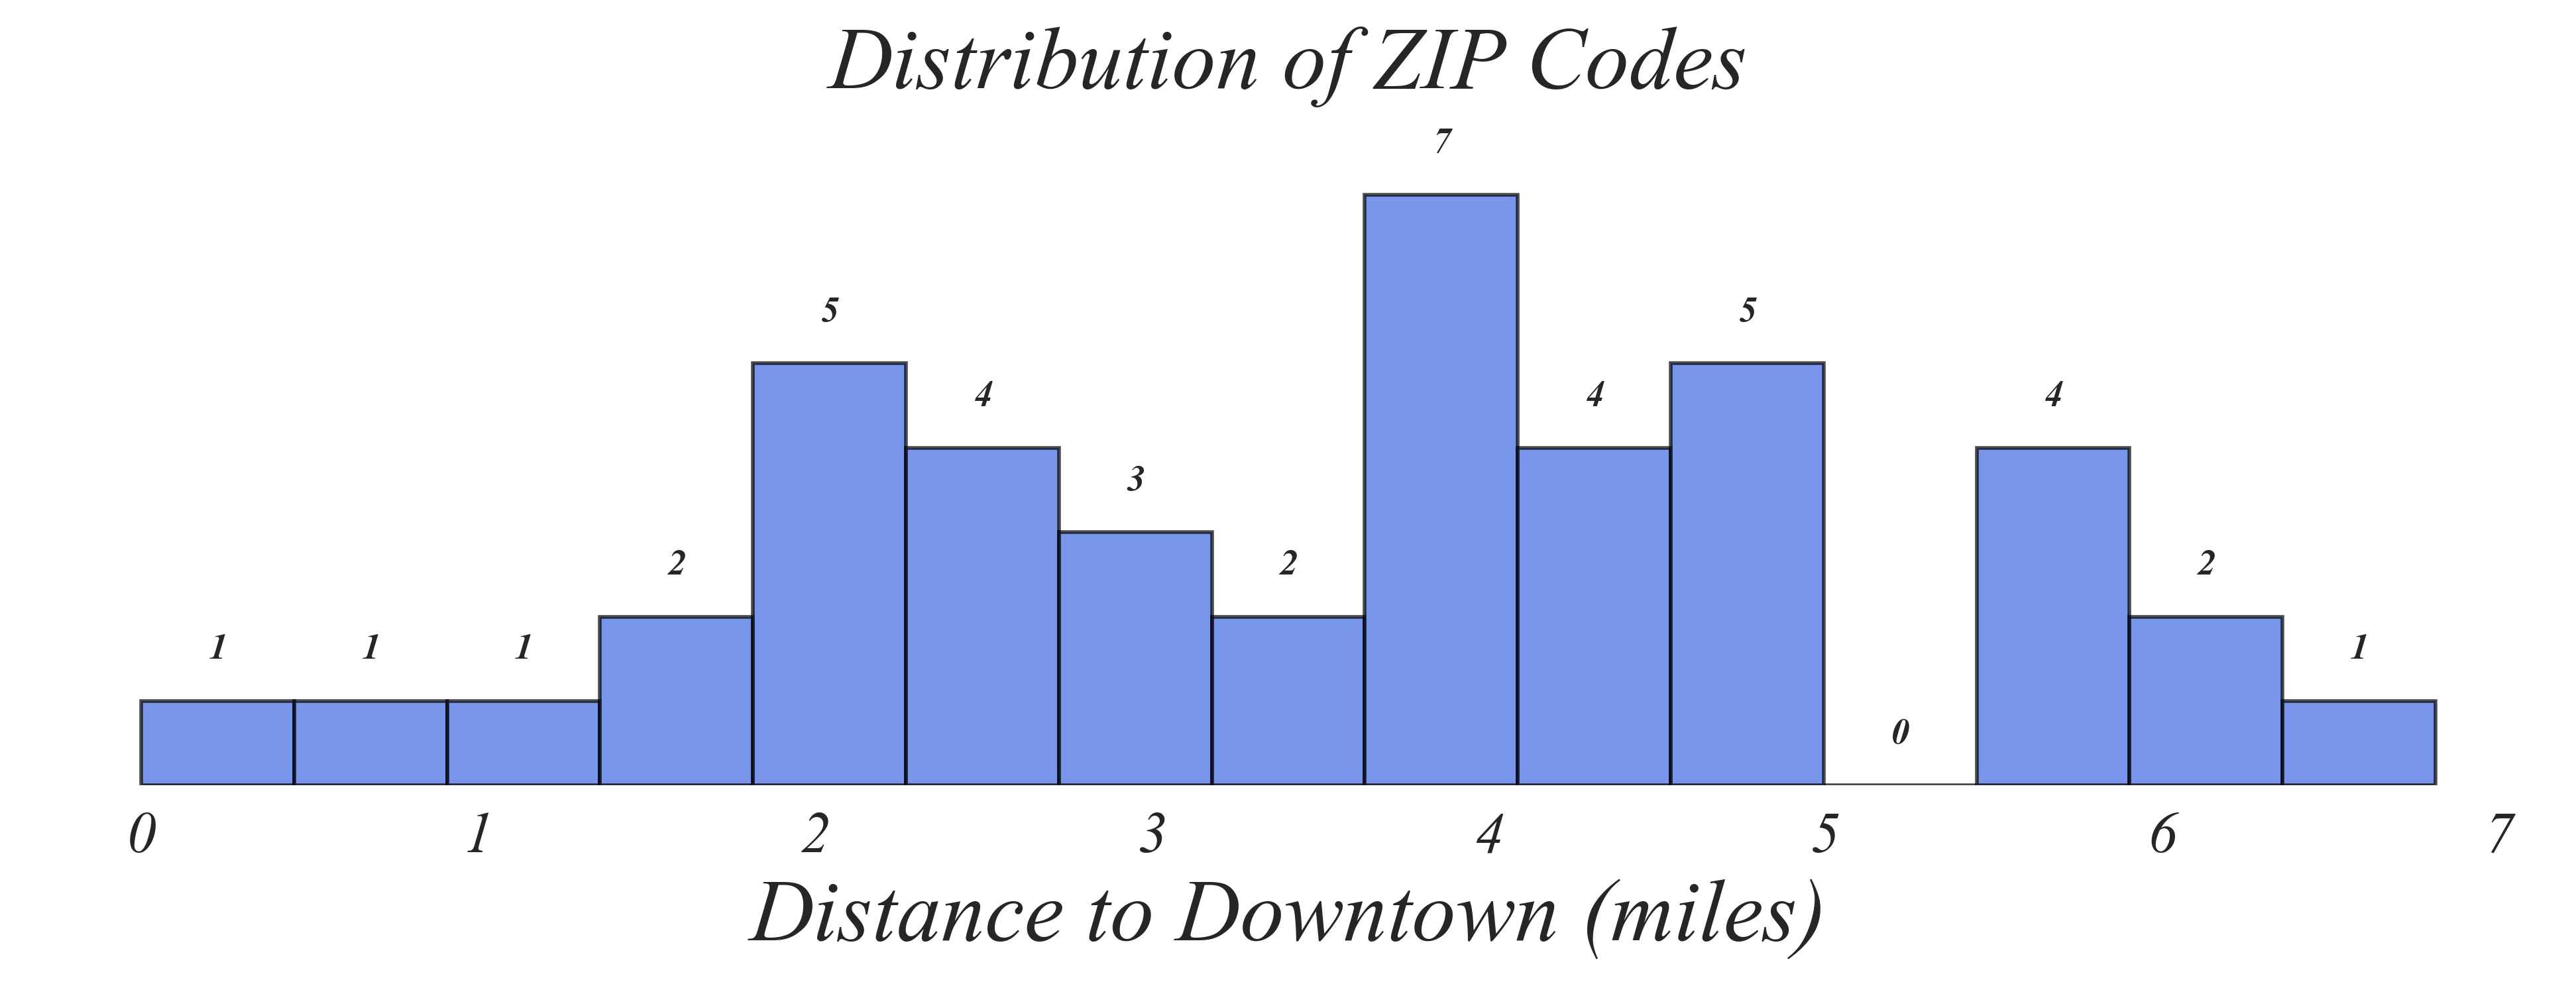

In [193]:
fig, ax = Weid_Fig(height=4, fontsize=24)

bins = np.histogram_bin_edges(pittsburgh_zipcodes["distance_to_downtown"], bins=15)
counts, edges, patches = ax.hist(pittsburgh_zipcodes["distance_to_downtown"], bins=bins, color="royalblue", edgecolor="black", alpha=0.7)

# Add text labels above each bin
for count, edge in zip(counts, edges[:-1]):
    ax.text(edge + (edges[1] - edges[0]) / 2, count + 0.5, str(int(count)),
            ha='center', fontsize=10, fontweight="bold")

# Labels and title
ax.set_xlabel("Distance to Downtown (miles)")
ax.set_yticks([])
ax.set_ylim(0,8)
ax.set_title("Distribution of ZIP Codes")

plt.grid(False)
ax.set_frame_on(False)
plt.tight_layout()

plt.savefig('Part_2_3/i/6b.png')

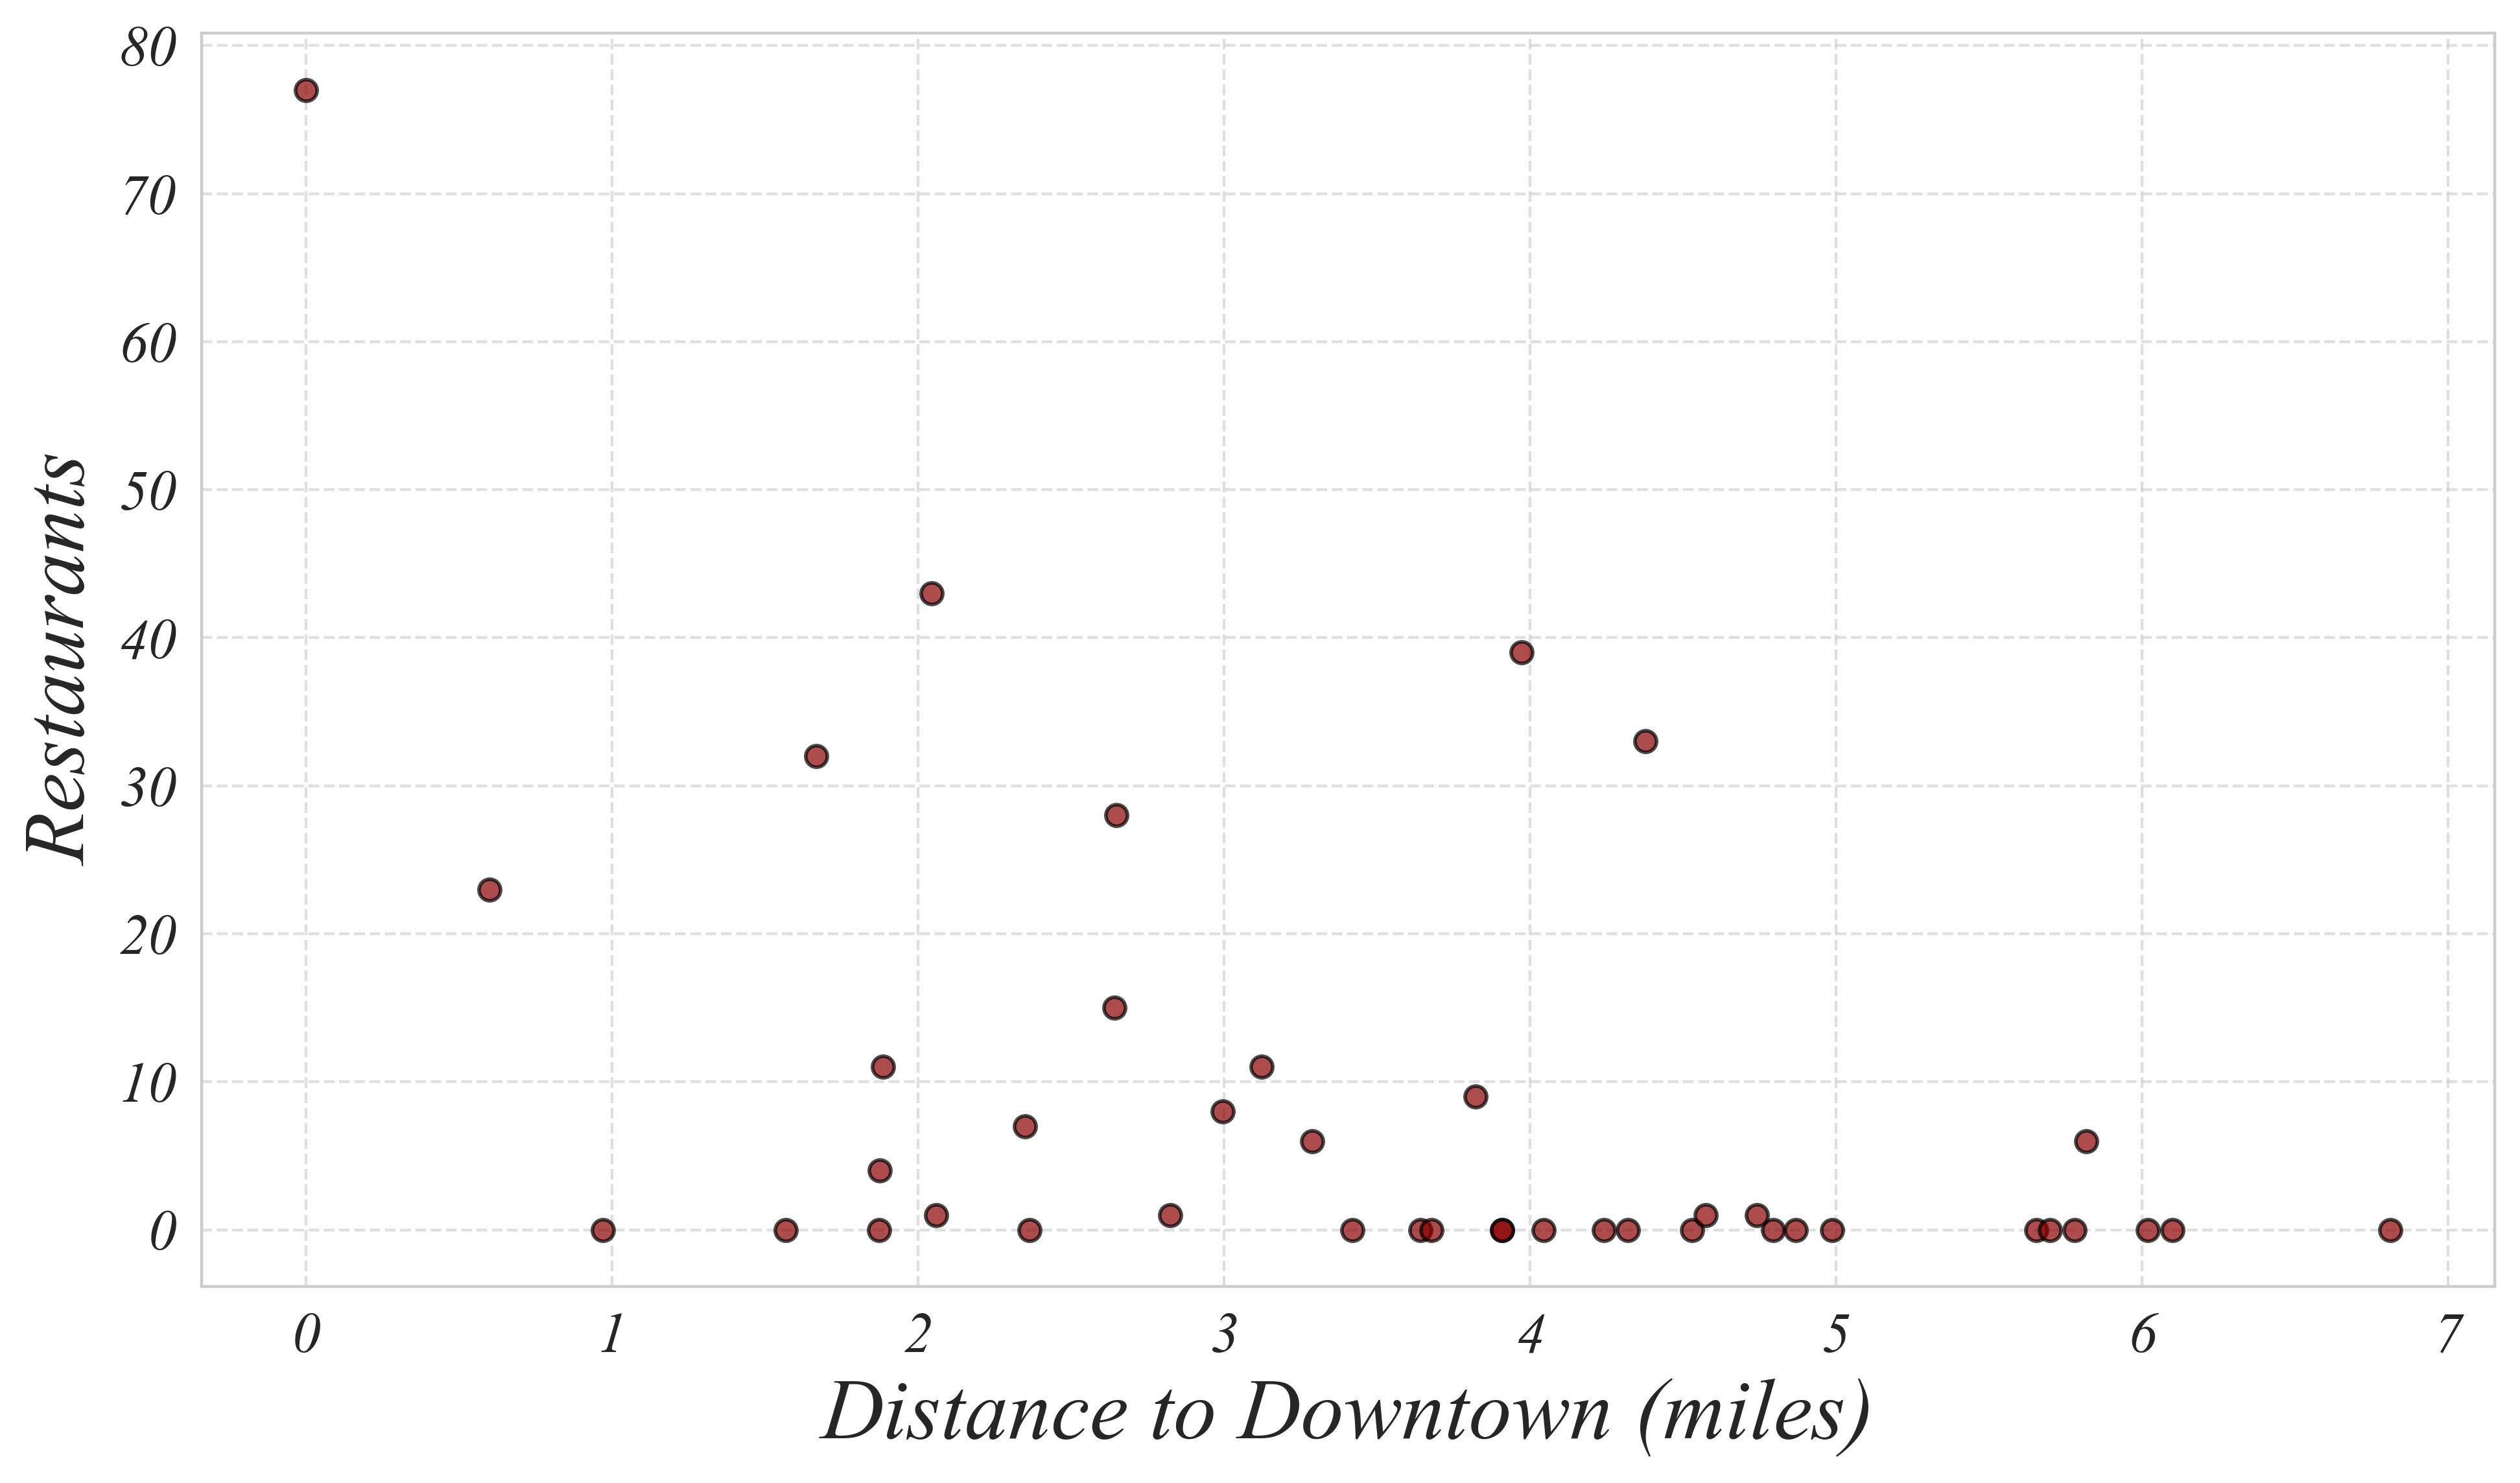

In [217]:
fig, ax = Weid_Fig(fontsize=24)

# Extract data for plotting
distances = pittsburgh_zipcodes["distance_to_downtown"]
restaurant_counts = pittsburgh_zipcodes["restaurant_count"]

# Create scatter plot
plt.scatter(distances, restaurant_counts, color="darkred", alpha=0.7, edgecolors="black")
plt.xlabel("Distance to Downtown (miles)")
plt.ylabel("Restaurants")
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()

plt.savefig('Part_2_3/i/7.png')

In [128]:
import pandas as pd

# Data: ZIP codes and their corresponding populations
data = {
    'ZIP Code': [
        '15222', '15229', '15202', '15122', '15236', '15224', '15260', '15227',
        '15221', '15206', '15213', '15219', '15211', '15207', '15215', '15223',
        '15106', '15136', '15217', '15201', '15147', '15218', '15220', '15204',
        '15237', '15235', '15205', '15216', '15226', '15234', '15209', '15210',
        '15290', '15232', '15238', '15214', '15208', '15120', '15233', '15212',
        '15282', '15203'
    ],
    'Population': [
        2_506, 14_085, 20_329, 0, 30_240, 9_787, 0, 29_178,
        31_652, 29_316, 29_410, 11_141, 11_524, 11_514, 12_443, 7_676,
        0, 0, 26_788, 13_017, 0, 14_284, 17_958, 8_465,
        42_216, 36_473, 23_264, 23_794, 14_021, 14_364, 12_854, 26_754,
        0, 10_892, 13_721, 15_026, 10_955, 0, 2_714, 27_999,
        0, 10_720
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
df.head()


ZIP Code  Population
0    15222        2506
1    15229       14085
2    15202       20329
3    15122           0
4    15236       30240

In [133]:
import folium

# Ensure the ZIP Code column in data matches the format of pittsburgh_zipcodes
df["Zip Code"] = df["ZIP Code"].astype(str)

# Merge population data into the GeoDataFrame
#pittsburgh_zipcodes = pittsburgh_zipcodes.merge(df, left_on="ZCTA5CE20", right_on="Zip Code", how="left")

# Fill missing population values with 0
#pittsburgh_zipcodes["Population"] = pittsburgh_zipcodes["Population"].fillna(0)

# Create a Folium map centered on Pittsburgh
m = folium.Map(location=[40.4406, -79.9959], zoom_start=12)

# Define blue color scale for population
def get_color(population):
    if population > 35000:
        return "#08306b"  # Dark Blue
    elif population > 25000:
        return "#08519c"  # Medium Dark Blue
    elif population > 20000:
        return "#2171b5"  # Medium Blue
    elif population > 15000:
        return "#6baed6"  # Light Blue
    elif population > 10000:
        return "#bdd7e7"  # Very Light Blue
    else:
        return "#deebf7"  # Pale Blue

# Add ZIP code polygons colored by population
folium.GeoJson(
    pittsburgh_zipcodes,
    name="Population by ZIP Code",
    style_function=lambda x: {
        "fillColor": get_color(x["properties"]["Population"]),
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.7  # Adjusted for better visibility
    },
    tooltip=folium.GeoJsonTooltip(
        fields=["ZCTA5CE20", "Population"],
        aliases=["ZIP Code:", "Population:"],
        localize=True
    )
).add_to(m)

# Show the interactive map
m.save('Part_2_3/i/3.html')


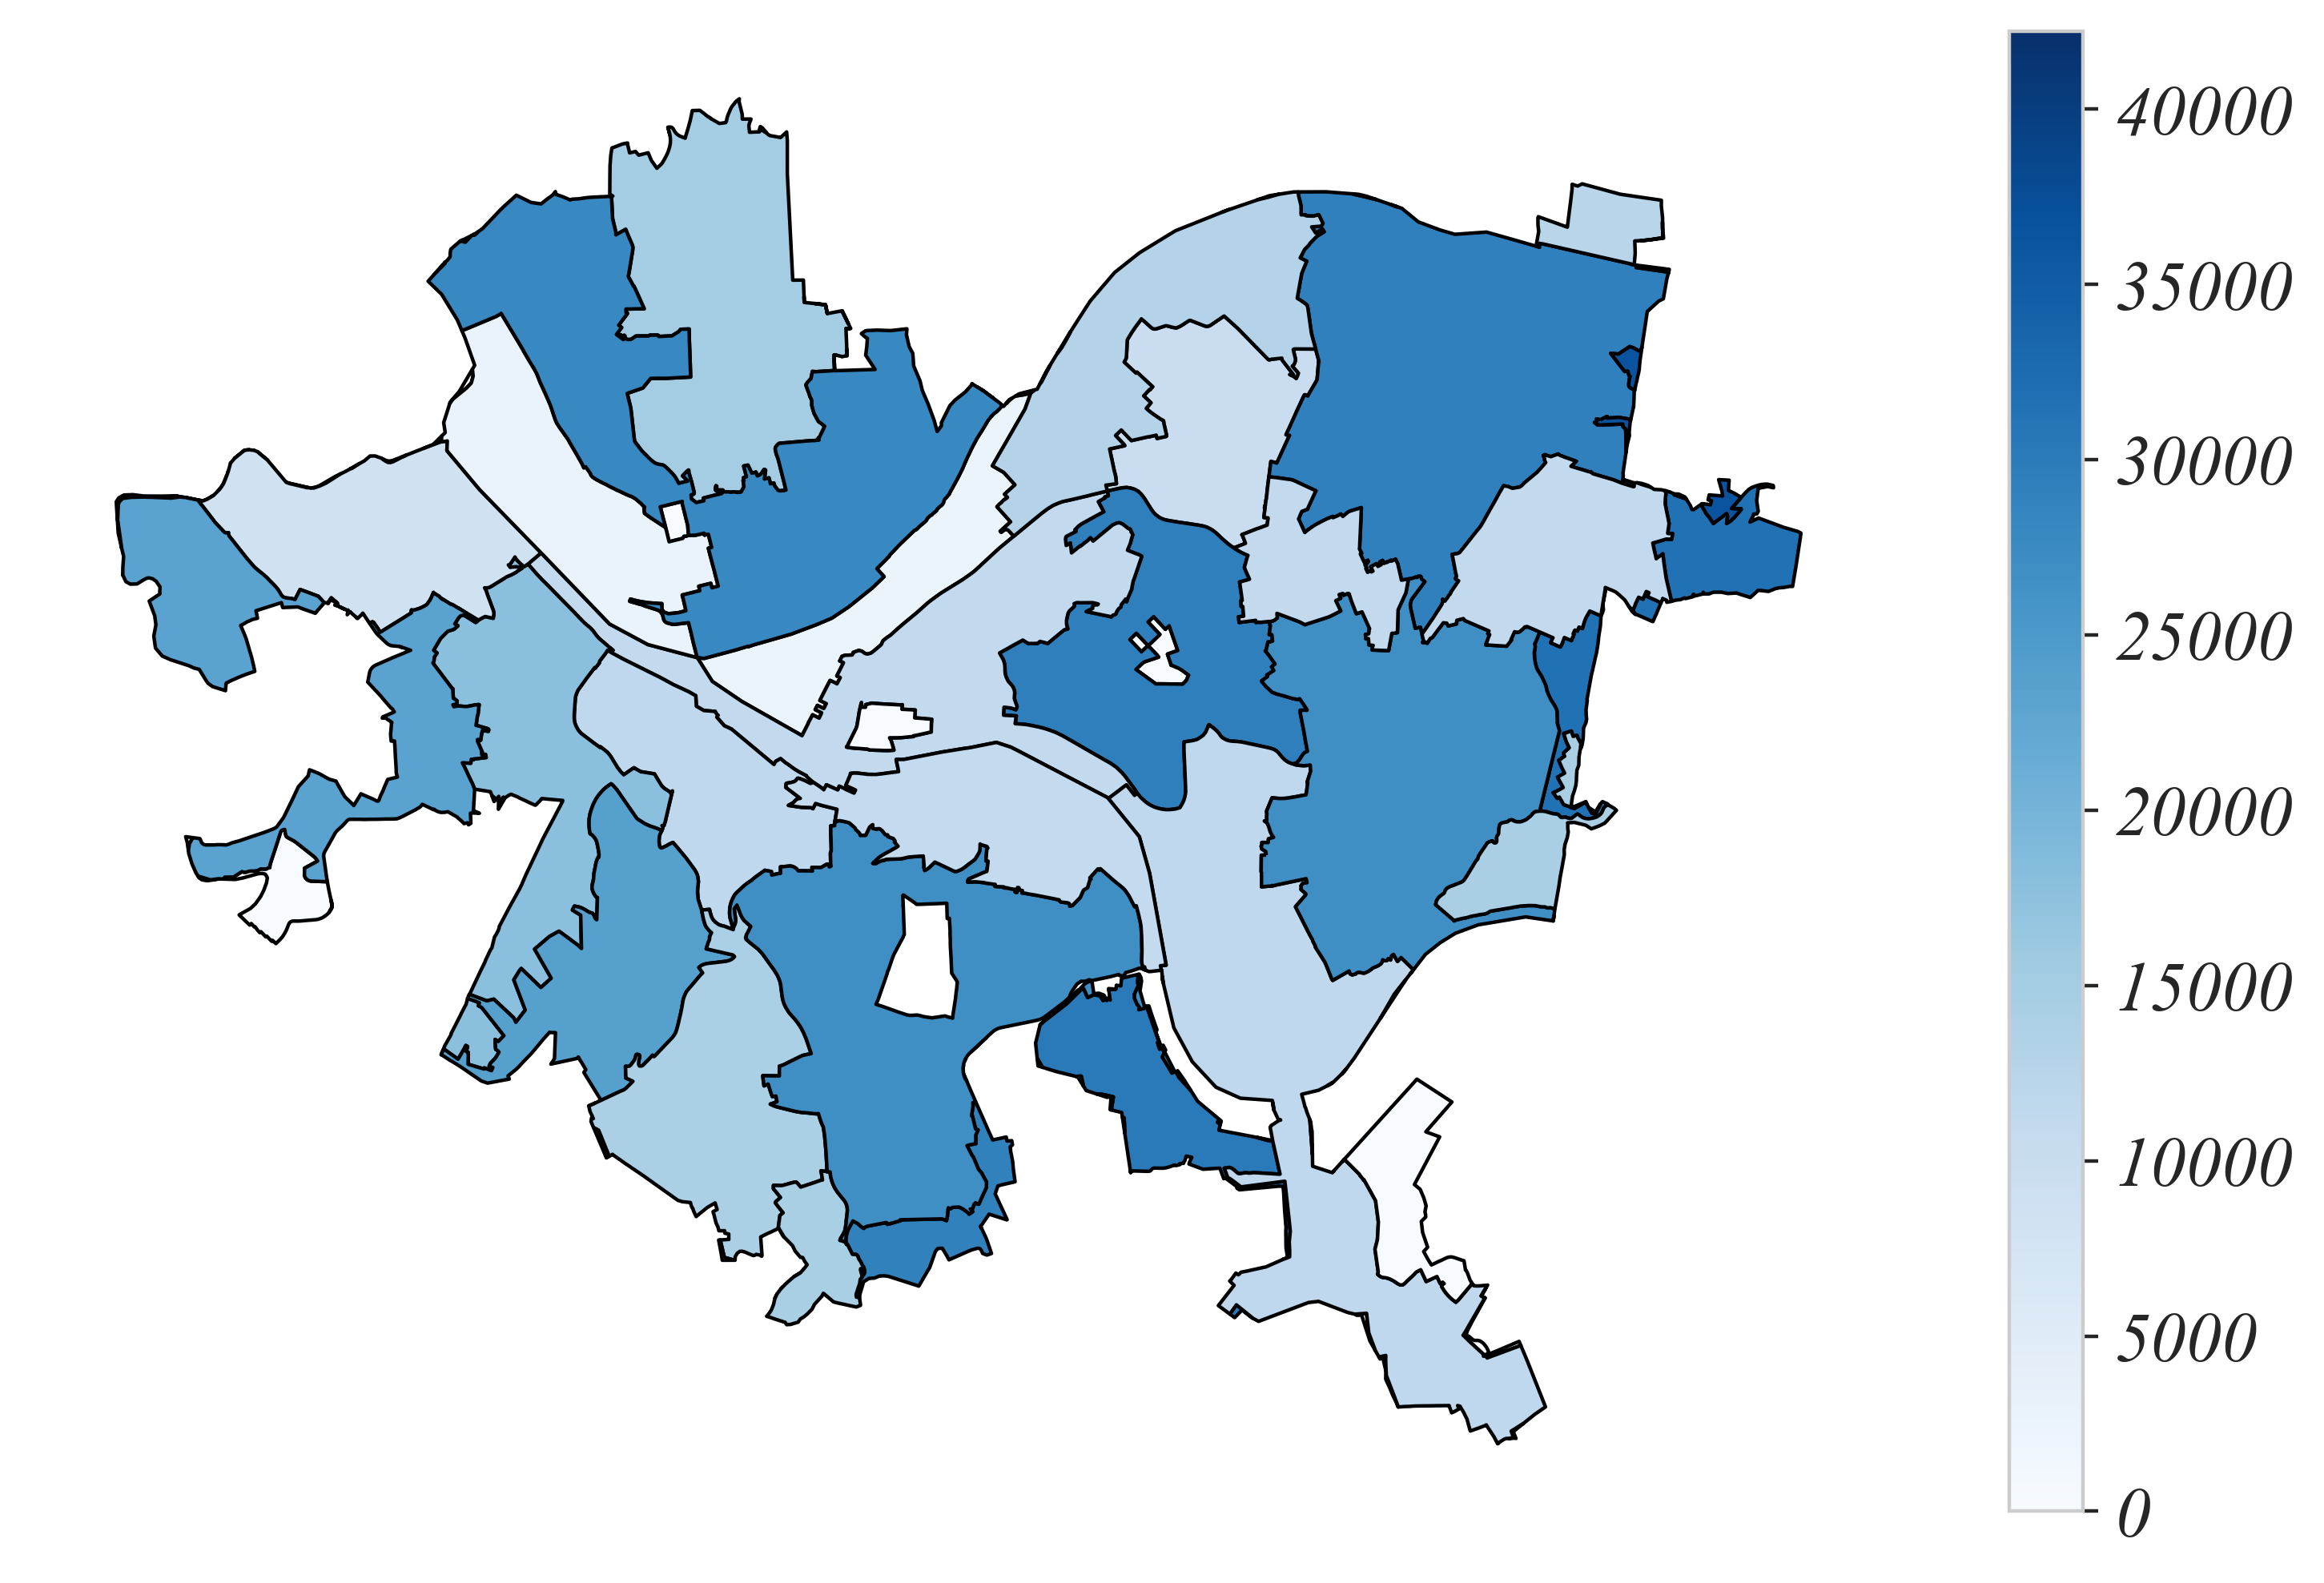

In [126]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import matplotlib.colors as mcolors

fig, ax = Weid_Fig(fontsize=24)

# Ensure 'Population' column exists and is numeric
pittsburgh_zipcodes["Population"] = pittsburgh_zipcodes["Population"].fillna(0).astype(float)

# Normalize population values for color mapping
norm = plt.Normalize(vmin=pittsburgh_zipcodes["Population"].min(), vmax=pittsburgh_zipcodes["Population"].max())
cmap = plt.get_cmap("Blues")

# Plot the ZIP code areas with population-based coloring
pittsburgh_zipcodes.plot(ax=ax, linewidth=0.8, edgecolor="black",
                         facecolor=[cmap(norm(val)) for val in pittsburgh_zipcodes["Population"]])

# Add a color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("")

# Title and axis formatting
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

plt.savefig('Part_2_3/i/3.png')


## Homework

#### Data

In [34]:
# This dataset is too large to keep around
temperature = pd.read_csv('data/GlobalLandTemperaturesByCity.csv')
temperature = temperature[temperature.Country == 'United States']
averages = temperature.groupby('City')['AverageTemperature'].mean()
temperature = pd.DataFrame({'city': averages.index, 'avg_temp': averages.values})
temperature.to_csv('data/US_Land_Temp_By_City.csv')

In [48]:
cities = pd.read_csv('data/uscities.csv')
temperature = pd.read_csv('data/US_Land_Temp_By_City.csv', index_col=0)
data = pd.merge(temperature.reset_index(), cities, on='city')

keep_cols = [
    'city', 'avg_temp', 'state_id', 'county_fips', 
    'lat', 'lng', 'population', 'timezone'
]
subdata = data[keep_cols]
subdata.to_csv('data/US_Cities.csv')

In [51]:
income = pd.read_csv('data/MedianHouseholdIncome2015.csv', encoding='latin-1')
income['city'] = income['City'].str.replace(r'\s(city|town)$', '', regex=True)
income['state_id'] = income['Geographic Area']
income['median_income'] = income['Median Income']

keep_cols = ['city', 'state_id', 'median_income']
income = income[keep_cols]

all_data = pd.merge(subdata, income, on=['city', 'state_id'])
all_data.to_csv('data/US_Cities_Income.csv')

<Axes: xlabel='lat', ylabel='avg_temp'>

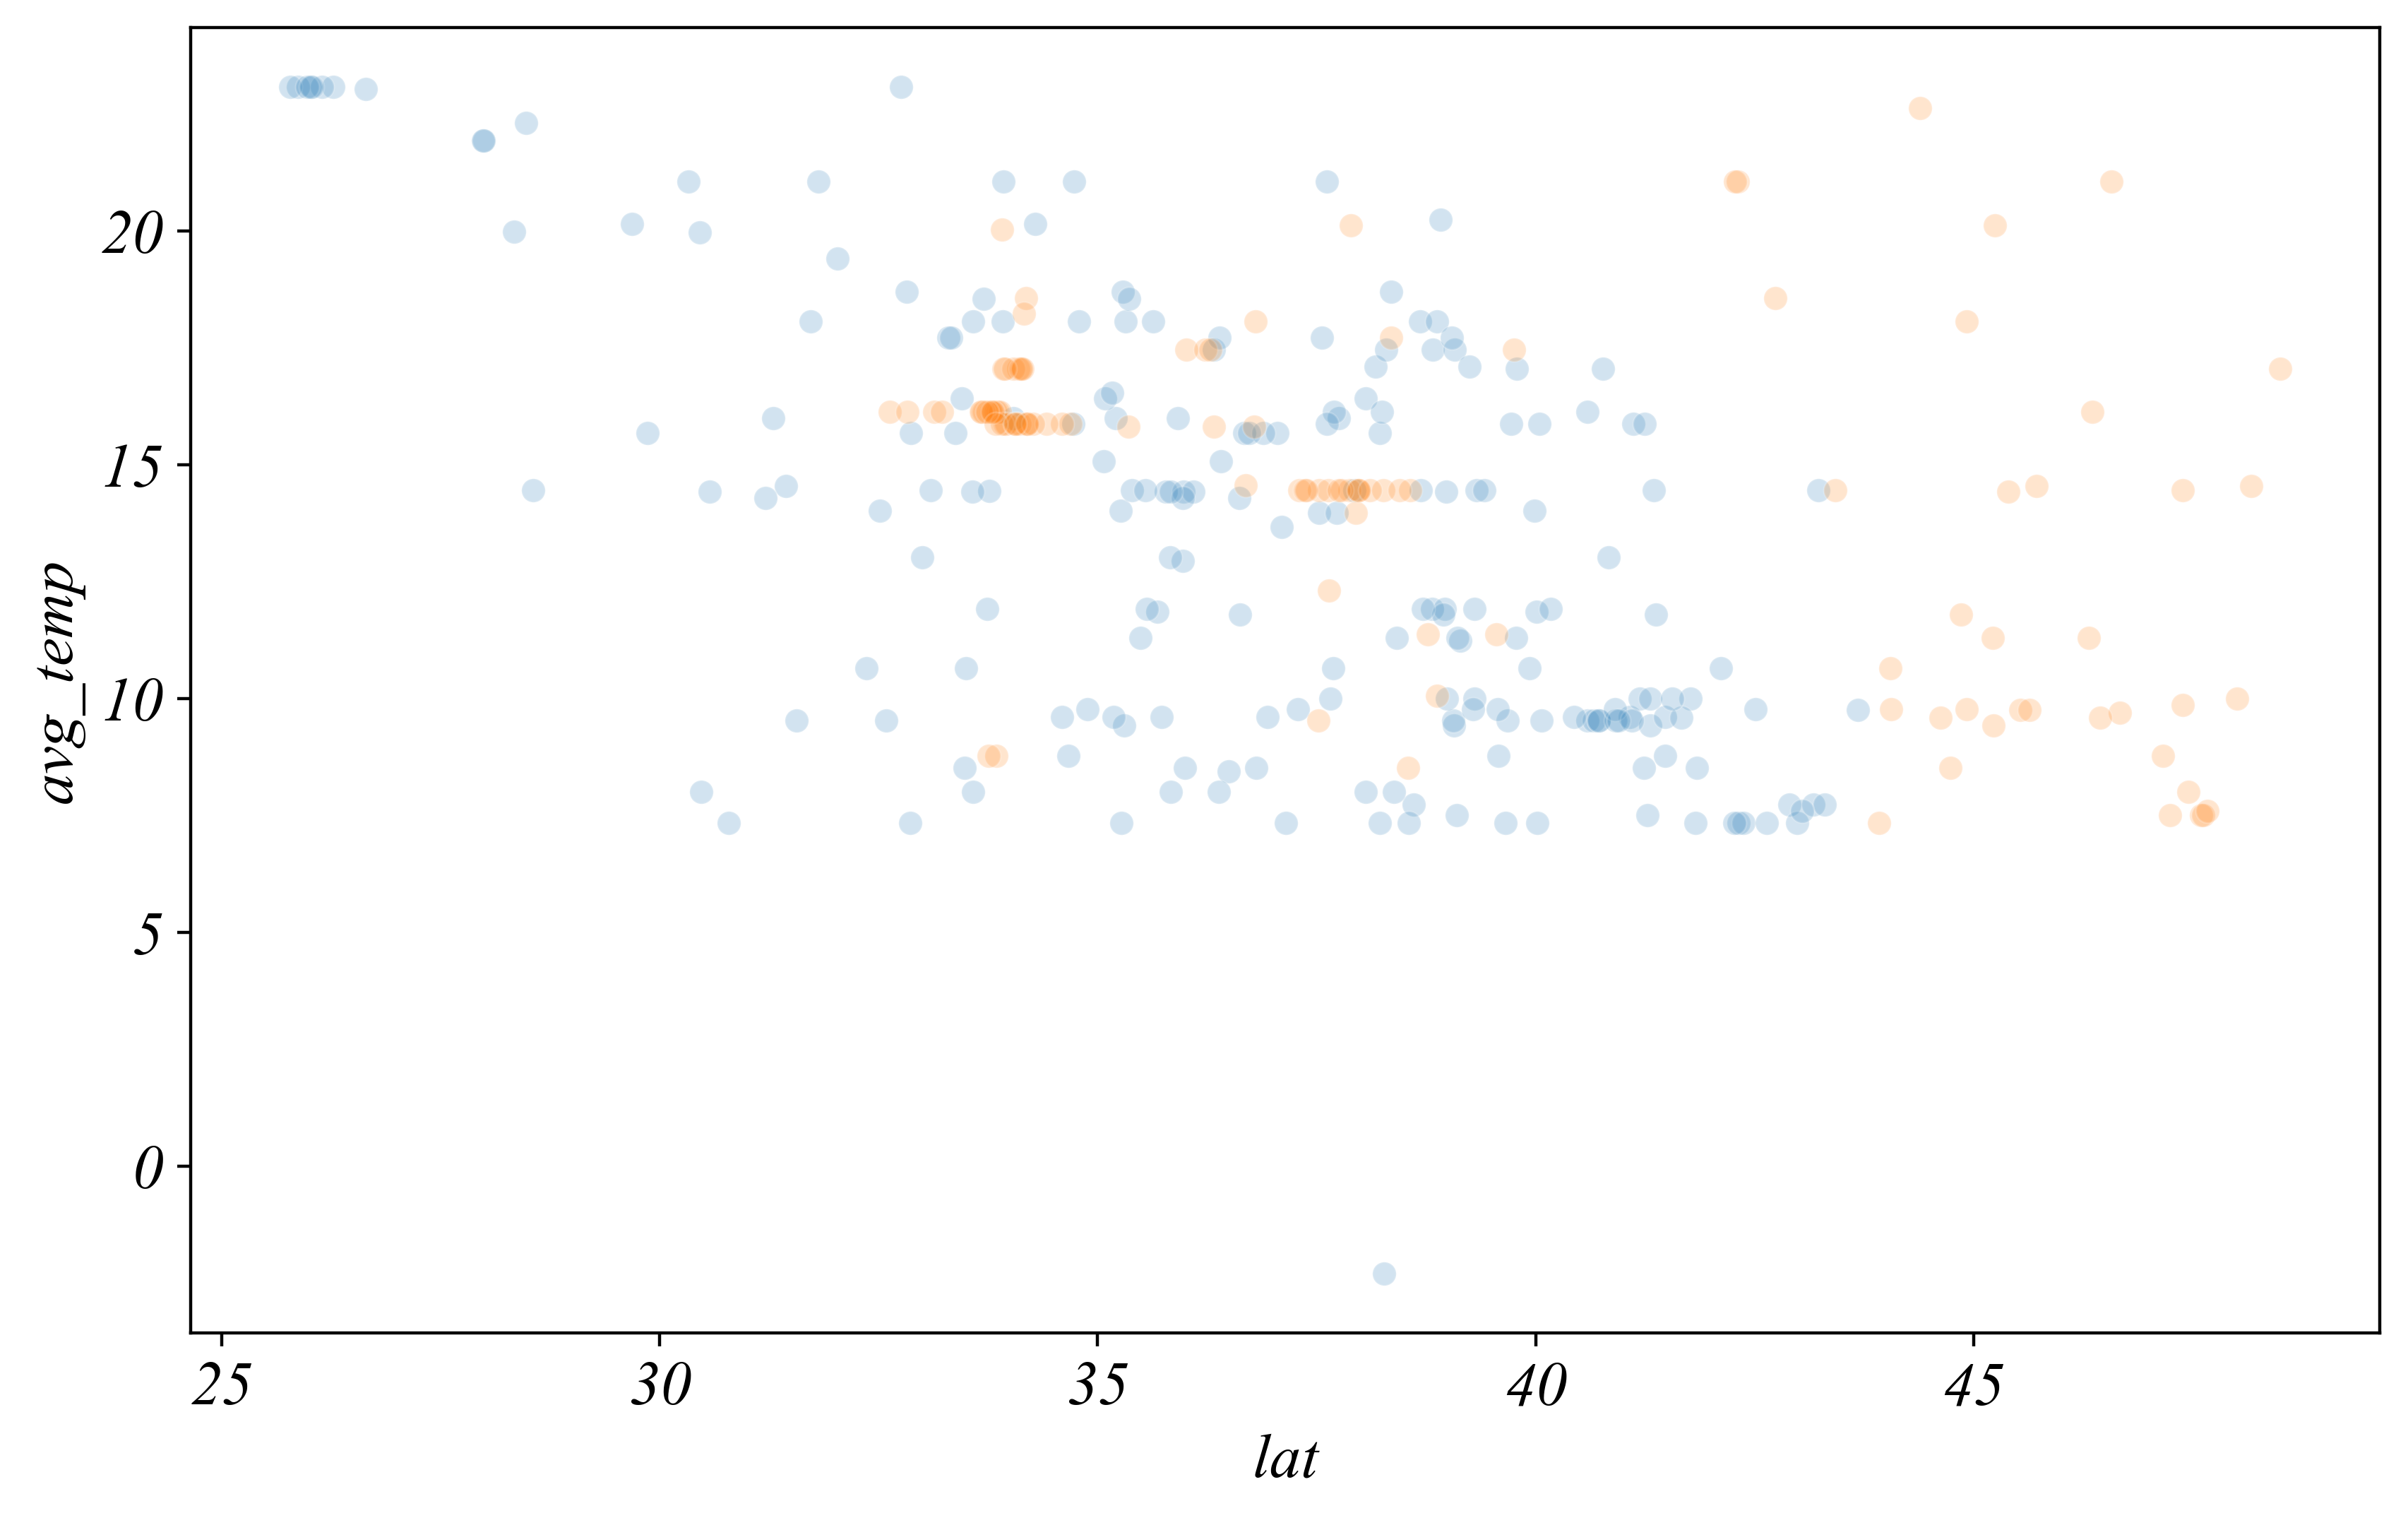

In [68]:
# Data
data = pd.read_csv('data/US_Cities_Income.csv', index_col=0)
nydata = data[data.timezone == 'America/New_York']
ladata = data[data.timezone == 'America/Los_Angeles']

# Figure
plt.figure(figsize=(10,6))
sns.scatterplot(nydata, x='lat', y='avg_temp', alpha=0.2)
sns.scatterplot(ladata, x='lat', y='avg_temp', alpha=0.2)

<Axes: xlabel='lng', ylabel='lat'>

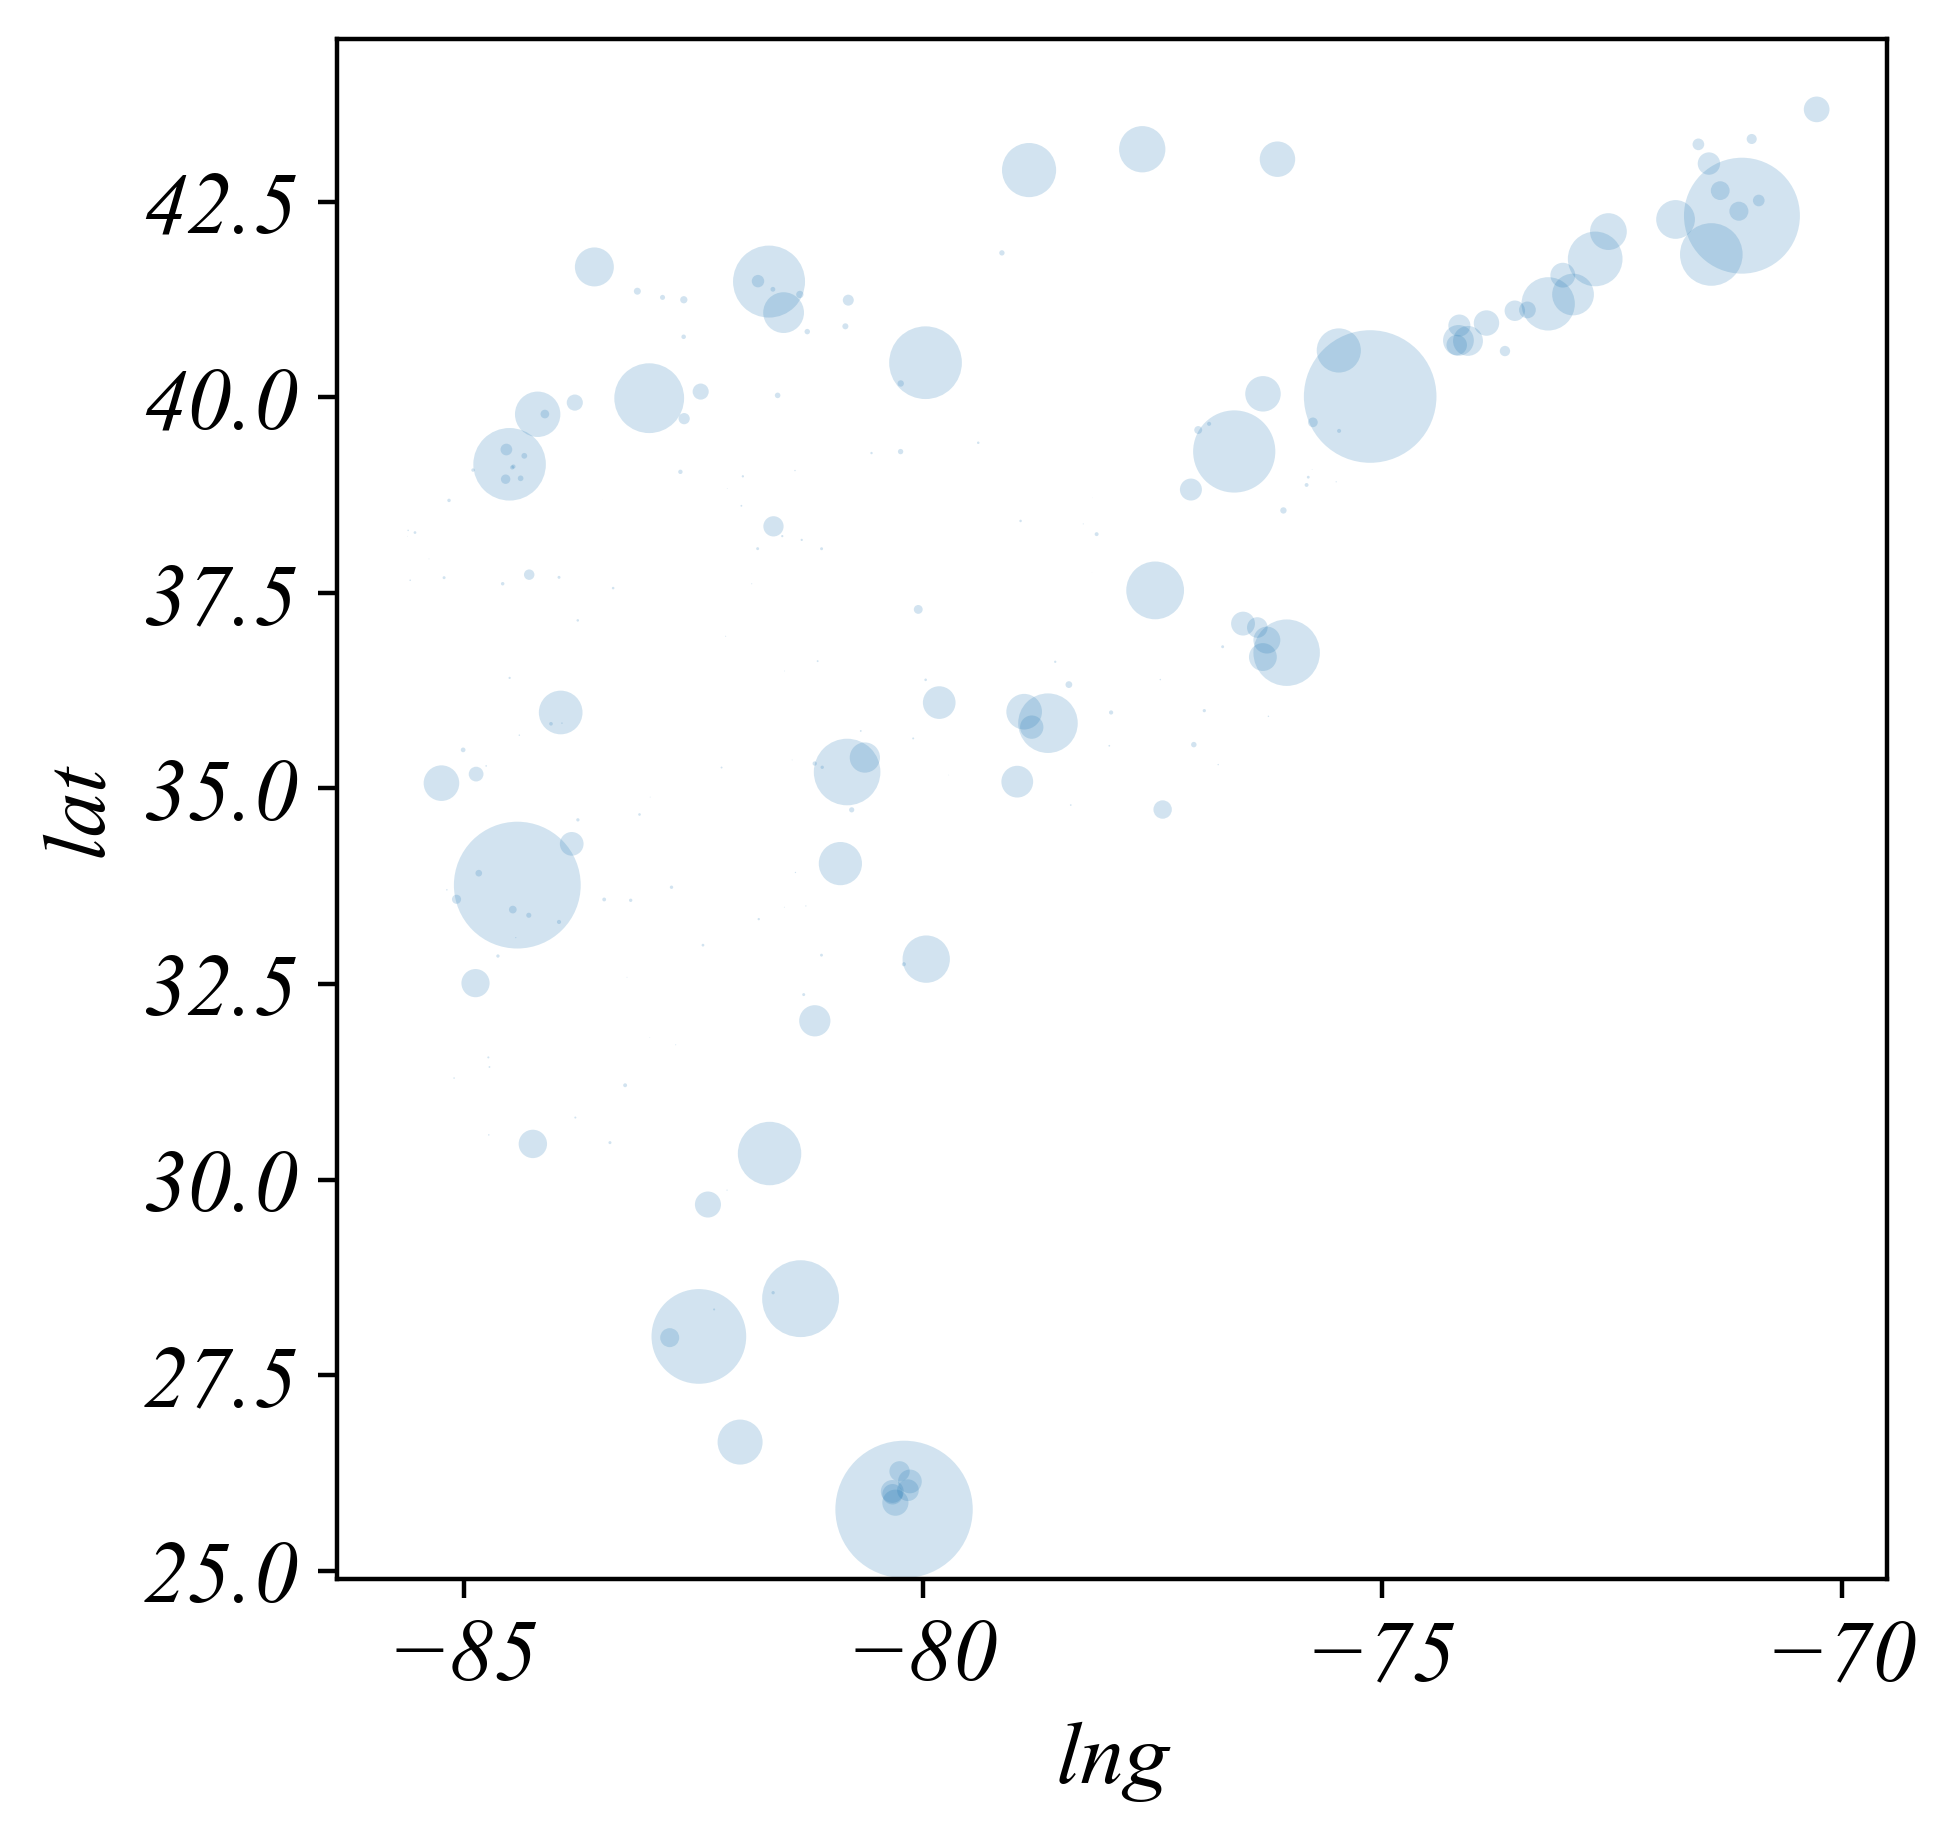

In [72]:
# Data
data = pd.read_csv('data/US_Cities_Income.csv')
data['population'] = data['population'] / 10000
data['population'] = data['population'].astype(float)

nydata = data[data.timezone == 'America/New_York']
ladata = data[data.timezone == 'America/Los_Angeles']

# Figure
plt.figure(figsize=(5,5))
sns.scatterplot(nydata, x='lng', y='lat', s=nydata['population'], alpha=0.2)

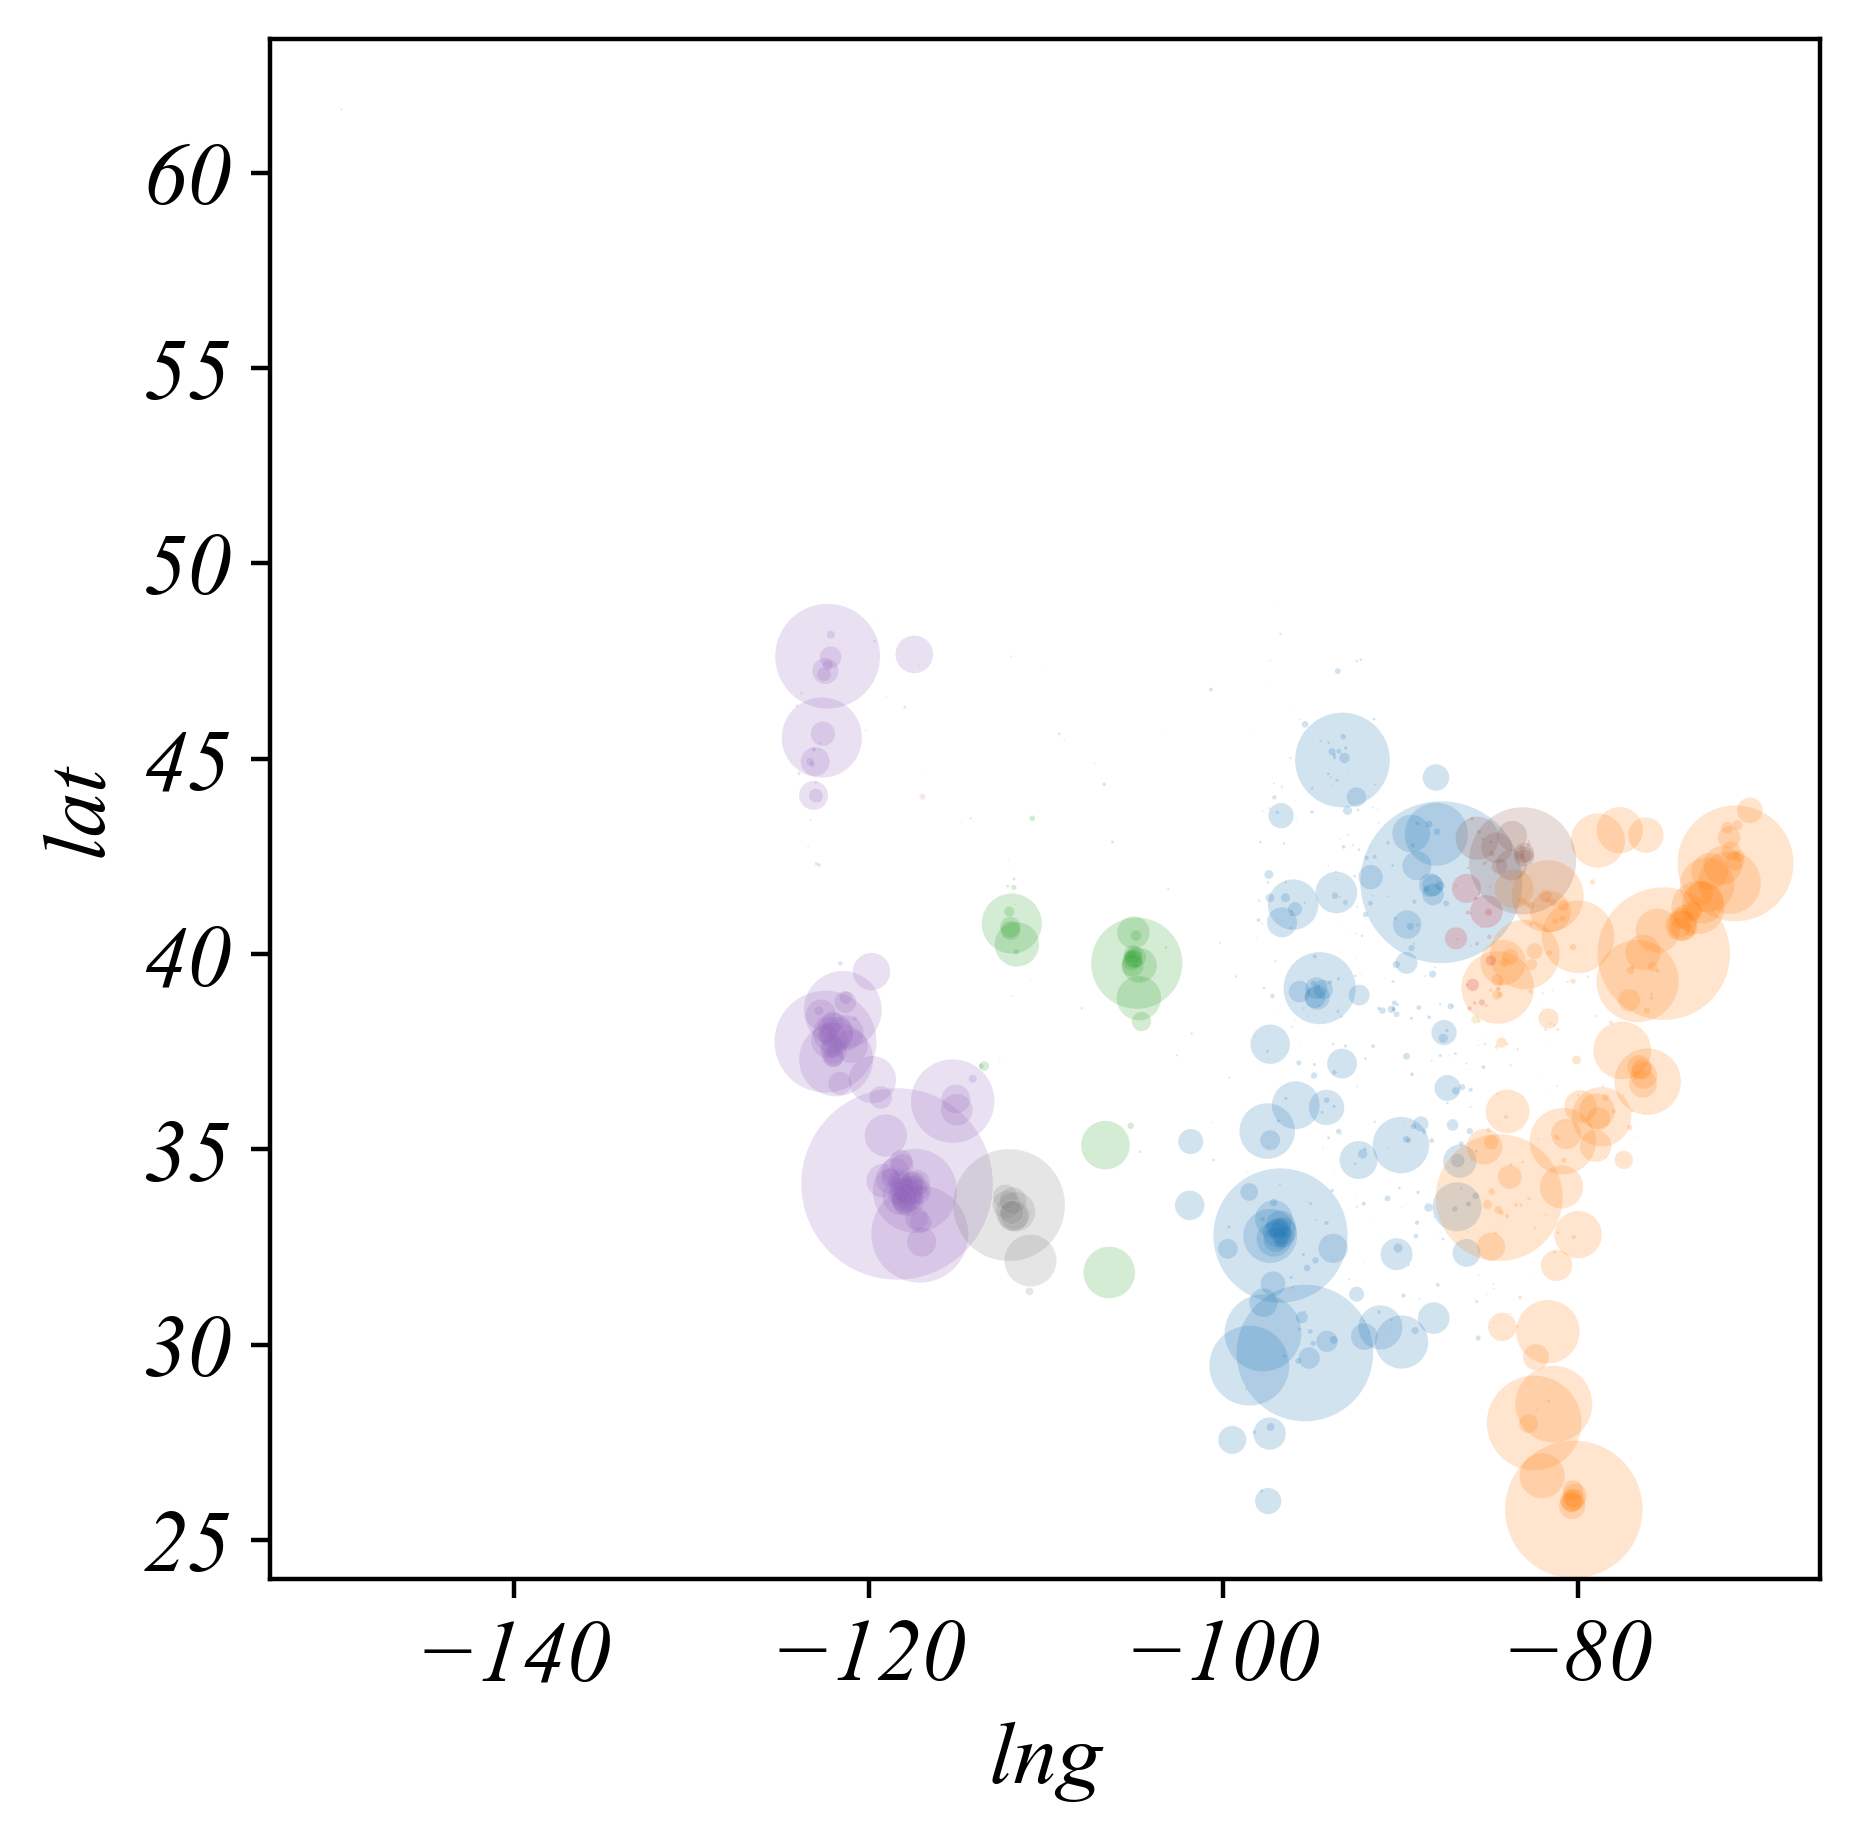

In [71]:
# Data
data = pd.read_csv('data/US_Cities_Income.csv')
data['population'] = data['population'] / 10000

# Figure
plt.figure(figsize=(5,5))

for timezone in all_data.timezone.unique():
    subdata = data[data.timezone == timezone]
    sns.scatterplot(subdata, x='lng', y='lat', s=subdata['population'], alpha=0.2)